<a href="https://colab.research.google.com/github/rishipython/BrainTumorSegmentationAI/blob/main/BrainSegmentationAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [433]:
import keras
from keras import backend as K
from keras.engine import Input, Model
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Activation, BatchNormalization, PReLU, Dropout, Conv2DTranspose
from keras.optimizers import Adam
from keras.layers.merge import concatenate
from keras.utils import to_categorical
import numpy as np
import nibabel as nib
import os
import tarfile as trf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.metrics import roc_auc_score, roc_curve, auc
from IPython.display import display
K.set_image_data_format("channels_last")

In [2]:
# Access GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Jan 18 05:17:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Access more memory
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
# See if Tensorflow is using GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Model Construction

In [5]:
def dice_coefficient(y_true, y_pred, epsilon=1e-6):
  axes = tuple(range(1, len(y_pred.shape)-1)) 
  dice_numerator = 2. * K.sum(y_true * y_pred, axis=axes)
  dice_denominator = K.sum(y_true + y_pred, axis=axes)
  dice_coefficient = K.mean((dice_numerator + epsilon) / (dice_denominator + epsilon))
  return dice_coefficient

def soft_dice_loss(y_true, y_pred, epsilon=1e-6): 
    axes = tuple(range(1, len(y_pred.shape)-1)) 
    numerator = 2. * K.sum(y_pred * y_true, axes)
    denominator = K.sum(K.square(y_pred) + K.square(y_true), axes)
    return 1 - K.mean((numerator + epsilon) / (denominator + epsilon))

In [6]:
'''
def unet(depth, input_size=(240, 240, 4), num_conv_layers=2, loss_function='binary_crossentropy', metrics=['accuracy'], lr=1e-4, data_format='channels_last'):
  if not isinstance(metrics, list):
    metrics = [metrics]
  layers = []
  input_layer = Input(input_size)
  layer = input_layer

  for i in range(depth):
    print(i)
    block = []
    for j in range(num_conv_layers):
      layer = Conv2D(64 * (2**i), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format=data_format)(layer)
    block.append(dc(layer))
    if i >= depth-2:
      layer = Dropout(0.5)(layer)
      block.append(dc(layer))
    print(i < depth-1)
    if i < depth-1:
      layer = MaxPooling2D(pool_size=(2, 2), data_format=data_format)(layer)
      block.append(dc(layer))
    layers.append(dc(block))
  for i in range(depth-1):
    block = []
    layer = Conv2D((64*pow(2, depth-1))/(2**(i+1)), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format=data_format)(UpSampling2D(size = (2,2))(layer))
    block.append(layer)
    down_block = layers[depth-2-i]
    if len(down_block) == 3:
      down_layer = down_block[1]
    else:
      down_layer = down_block[0]
    layer = concatenate([down_layer,layer], axis = 3)
    block.append(layer)
    for j in range(num_conv_layers):
      layer = Conv2D((64*pow(2, depth-1))/(2**(i+1)), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format=data_format)(layer)
    block.append(layer)
    layers.append(block)
  layer = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format=data_format)(layer)
  layer = Conv2D(1, 1, activation = 'sigmoid', data_format=data_format)(layer)

  model = Model(inputs=input_layer, outputs=layer)
  model.compile(optimizer = Adam(lr = lr), loss = loss_function, metrics = metrics)
  return model
'''

"\ndef unet(depth, input_size=(240, 240, 4), num_conv_layers=2, loss_function='binary_crossentropy', metrics=['accuracy'], lr=1e-4, data_format='channels_last'):\n  if not isinstance(metrics, list):\n    metrics = [metrics]\n  layers = []\n  input_layer = Input(input_size)\n  layer = input_layer\n\n  for i in range(depth):\n    print(i)\n    block = []\n    for j in range(num_conv_layers):\n      layer = Conv2D(64 * (2**i), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format=data_format)(layer)\n    block.append(dc(layer))\n    if i >= depth-2:\n      layer = Dropout(0.5)(layer)\n      block.append(dc(layer))\n    print(i < depth-1)\n    if i < depth-1:\n      layer = MaxPooling2D(pool_size=(2, 2), data_format=data_format)(layer)\n      block.append(dc(layer))\n    layers.append(dc(block))\n  for i in range(depth-1):\n    block = []\n    layer = Conv2D((64*pow(2, depth-1))/(2**(i+1)), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he

In [331]:
def unet(depth, n_labels=1, final_activation='sigmoid', input_size=(240, 240, 4), num_conv_layers=2, loss_function=soft_dice_loss, metrics=dice_coefficient, lr=1e-4, data_format='channels_last'):
  if not isinstance(metrics, list):
    metrics = [metrics]
  layers = []

  # Input
  input_layer = Input(input_size)
  layers.append([input_layer])

  for b in range(depth-2):
    block = []
    conv = [layers[-1][-1]]
    num_filters = 64 * (2**b)
    for i in range(num_conv_layers):
      conv.append(Conv2D(num_filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format=data_format)(conv[-1]))
    block.append(conv[-1])
    block.append(MaxPooling2D(pool_size=(2, 2), data_format=data_format)(block[-1]))
    layers.append(block)

  b = depth-2
  block4 = []
  conv = [layers[-1][-1]]
  num_filters = 64 * (2**b)
  for i in range(num_conv_layers):
    conv.append(Conv2D(num_filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format=data_format)(conv[-1]))
  block4.append(conv[-1])
  block4.append(Dropout(0.5)(block4[-1]))
  block4.append(MaxPooling2D(pool_size=(2, 2), data_format=data_format)(block4[-1]))
  layers.append(block4)

  b = depth-1
  block5 = []
  conv = [layers[-1][-1]]
  num_filters = 64 * (2**b)
  for i in range(num_conv_layers):
    conv.append(Conv2D(num_filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format=data_format)(conv[-1]))
  block5.append(conv[-1])
  block5.append(Dropout(0.5)(block5[-1]))
  layers.append(block5)


  for b in range(depth-2):
    block = [layers[-1][-1]]
    num_filters = (64 * (2**(depth-2-b)))
    block.append(Conv2D(num_filters, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format=data_format)(UpSampling2D(size = (2,2), data_format=data_format)(block[-1])))
    if b == 0:
      down_layer = 1
    else:
      down_layer = 0
    block.append(concatenate([layers[depth-1-b][down_layer],block[-1]], axis = 3))
    conv = [block[-1]]
    for i in range(num_conv_layers):
      conv.append(Conv2D(num_filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format=data_format)(conv[-1]))
    block.append(conv[-1])
    layers.append(block)

  b = depth-2
  block = [layers[-1][-1]]
  num_filters = (64 * (2**(depth-2-b)))
  block.append(Conv2D(num_filters, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format=data_format)(UpSampling2D(size = (2,2), data_format=data_format)(block[-1])))
  block.append(concatenate([layers[1][0], block[-1]], axis = 3))
  conv = [block[-1]]
  for i in range(num_conv_layers):
    conv.append(Conv2D(num_filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format=data_format)(conv[-1]))
  conv.append(Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format=data_format)(conv[-1]))
  block.append(conv[-1])
  layers.append(block)

  output_layer = Conv2D(n_labels, 1, activation = 'sigmoid', data_format=data_format)(layers[-1][-1])
  layers.append([output_layer])

  model = Model(inputs=input_layer, outputs=output_layer)
  model.compile(optimizer = Adam(lr = lr), loss = loss_function, metrics = metrics)

  return model

In [8]:
# Test unet function
'''
model = unet(5, n_labels=4)
x = np.ones((240, 240, 4))
x = np.expand_dims(x, axis=0)
y = np.ones((240, 240, 4))
y = np.expand_dims(y, axis=0)
history = model.fit(x=x, y=y, epochs=10)
'''

'\nmodel = unet(5, n_labels=4)\nx = np.ones((240, 240, 4))\nx = np.expand_dims(x, axis=0)\ny = np.ones((240, 240, 4))\ny = np.expand_dims(y, axis=0)\nhistory = model.fit(x=x, y=y, epochs=10)\n'

# Data Preprocessing

In [9]:
def configurePath(path, dir="Dataset/Task01_BrainTumour/"):
  return dir + path[2:]

In [10]:
# Data and dataset
data = { 
"name": "BRATS", 
"description": "Gliomas segmentation tumour and oedema in on brain images",
"reference": "https://www.med.upenn.edu/sbia/brats2017.html",
"licence":"CC-BY-SA 4.0",
"release":"2.0 04/05/2018",
"tensorImageSize": "4D",
"modality": { 
	 "0": "FLAIR", 
	 "1": "T1w", 
	 "2": "t1gd",
	 "3": "T2w"
 },  
 "labels": { 
	 "0": "background", 
	 "1": "edema",
	 "2": "non-enhancing tumor",
	 "3": "enhancing tumour"
 }, 
 "numTraining": 484, 
 "numTest": 266,
 "training":[{"image":"./imagesTr/BRATS_457.nii.gz","label":"./labelsTr/BRATS_457.nii.gz"},{"image":"./imagesTr/BRATS_306.nii.gz","label":"./labelsTr/BRATS_306.nii.gz"},{"image":"./imagesTr/BRATS_206.nii.gz","label":"./labelsTr/BRATS_206.nii.gz"},{"image":"./imagesTr/BRATS_449.nii.gz","label":"./labelsTr/BRATS_449.nii.gz"},{"image":"./imagesTr/BRATS_318.nii.gz","label":"./labelsTr/BRATS_318.nii.gz"},{"image":"./imagesTr/BRATS_218.nii.gz","label":"./labelsTr/BRATS_218.nii.gz"},{"image":"./imagesTr/BRATS_434.nii.gz","label":"./labelsTr/BRATS_434.nii.gz"},{"image":"./imagesTr/BRATS_365.nii.gz","label":"./labelsTr/BRATS_365.nii.gz"},{"image":"./imagesTr/BRATS_265.nii.gz","label":"./labelsTr/BRATS_265.nii.gz"},{"image":"./imagesTr/BRATS_214.nii.gz","label":"./labelsTr/BRATS_214.nii.gz"},{"image":"./imagesTr/BRATS_314.nii.gz","label":"./labelsTr/BRATS_314.nii.gz"},{"image":"./imagesTr/BRATS_445.nii.gz","label":"./labelsTr/BRATS_445.nii.gz"},{"image":"./imagesTr/BRATS_269.nii.gz","label":"./labelsTr/BRATS_269.nii.gz"},{"image":"./imagesTr/BRATS_369.nii.gz","label":"./labelsTr/BRATS_369.nii.gz"},{"image":"./imagesTr/BRATS_438.nii.gz","label":"./labelsTr/BRATS_438.nii.gz"},{"image":"./imagesTr/BRATS_277.nii.gz","label":"./labelsTr/BRATS_277.nii.gz"},{"image":"./imagesTr/BRATS_377.nii.gz","label":"./labelsTr/BRATS_377.nii.gz"},{"image":"./imagesTr/BRATS_426.nii.gz","label":"./labelsTr/BRATS_426.nii.gz"},{"image":"./imagesTr/BRATS_095.nii.gz","label":"./labelsTr/BRATS_095.nii.gz"},{"image":"./imagesTr/BRATS_222.nii.gz","label":"./labelsTr/BRATS_222.nii.gz"},{"image":"./imagesTr/BRATS_195.nii.gz","label":"./labelsTr/BRATS_195.nii.gz"},{"image":"./imagesTr/BRATS_473.nii.gz","label":"./labelsTr/BRATS_473.nii.gz"},{"image":"./imagesTr/BRATS_322.nii.gz","label":"./labelsTr/BRATS_322.nii.gz"},{"image":"./imagesTr/BRATS_241.nii.gz","label":"./labelsTr/BRATS_241.nii.gz"},{"image":"./imagesTr/BRATS_410.nii.gz","label":"./labelsTr/BRATS_410.nii.gz"},{"image":"./imagesTr/BRATS_341.nii.gz","label":"./labelsTr/BRATS_341.nii.gz"},{"image":"./imagesTr/BRATS_330.nii.gz","label":"./labelsTr/BRATS_330.nii.gz"},{"image":"./imagesTr/BRATS_461.nii.gz","label":"./labelsTr/BRATS_461.nii.gz"},{"image":"./imagesTr/BRATS_187.nii.gz","label":"./labelsTr/BRATS_187.nii.gz"},{"image":"./imagesTr/BRATS_230.nii.gz","label":"./labelsTr/BRATS_230.nii.gz"},{"image":"./imagesTr/BRATS_087.nii.gz","label":"./labelsTr/BRATS_087.nii.gz"},{"image":"./imagesTr/BRATS_199.nii.gz","label":"./labelsTr/BRATS_199.nii.gz"},{"image":"./imagesTr/BRATS_099.nii.gz","label":"./labelsTr/BRATS_099.nii.gz"},{"image":"./imagesTr/BRATS_353.nii.gz","label":"./labelsTr/BRATS_353.nii.gz"},{"image":"./imagesTr/BRATS_402.nii.gz","label":"./labelsTr/BRATS_402.nii.gz"},{"image":"./imagesTr/BRATS_253.nii.gz","label":"./labelsTr/BRATS_253.nii.gz"},{"image":"./imagesTr/BRATS_384.nii.gz","label":"./labelsTr/BRATS_384.nii.gz"},{"image":"./imagesTr/BRATS_133.nii.gz","label":"./labelsTr/BRATS_133.nii.gz"},{"image":"./imagesTr/BRATS_284.nii.gz","label":"./labelsTr/BRATS_284.nii.gz"},{"image":"./imagesTr/BRATS_033.nii.gz","label":"./labelsTr/BRATS_033.nii.gz"},{"image":"./imagesTr/BRATS_150.nii.gz","label":"./labelsTr/BRATS_150.nii.gz"},{"image":"./imagesTr/BRATS_050.nii.gz","label":"./labelsTr/BRATS_050.nii.gz"},{"image":"./imagesTr/BRATS_021.nii.gz","label":"./labelsTr/BRATS_021.nii.gz"},{"image":"./imagesTr/BRATS_296.nii.gz","label":"./labelsTr/BRATS_296.nii.gz"},{"image":"./imagesTr/BRATS_121.nii.gz","label":"./labelsTr/BRATS_121.nii.gz"},{"image":"./imagesTr/BRATS_396.nii.gz","label":"./labelsTr/BRATS_396.nii.gz"},{"image":"./imagesTr/BRATS_288.nii.gz","label":"./labelsTr/BRATS_288.nii.gz"},{"image":"./imagesTr/BRATS_388.nii.gz","label":"./labelsTr/BRATS_388.nii.gz"},{"image":"./imagesTr/BRATS_042.nii.gz","label":"./labelsTr/BRATS_042.nii.gz"},{"image":"./imagesTr/BRATS_142.nii.gz","label":"./labelsTr/BRATS_142.nii.gz"},{"image":"./imagesTr/BRATS_017.nii.gz","label":"./labelsTr/BRATS_017.nii.gz"},{"image":"./imagesTr/BRATS_117.nii.gz","label":"./labelsTr/BRATS_117.nii.gz"},{"image":"./imagesTr/BRATS_009.nii.gz","label":"./labelsTr/BRATS_009.nii.gz"},{"image":"./imagesTr/BRATS_109.nii.gz","label":"./labelsTr/BRATS_109.nii.gz"},{"image":"./imagesTr/BRATS_074.nii.gz","label":"./labelsTr/BRATS_074.nii.gz"},{"image":"./imagesTr/BRATS_174.nii.gz","label":"./labelsTr/BRATS_174.nii.gz"},{"image":"./imagesTr/BRATS_105.nii.gz","label":"./labelsTr/BRATS_105.nii.gz"},{"image":"./imagesTr/BRATS_005.nii.gz","label":"./labelsTr/BRATS_005.nii.gz"},{"image":"./imagesTr/BRATS_178.nii.gz","label":"./labelsTr/BRATS_178.nii.gz"},{"image":"./imagesTr/BRATS_078.nii.gz","label":"./labelsTr/BRATS_078.nii.gz"},{"image":"./imagesTr/BRATS_480.nii.gz","label":"./labelsTr/BRATS_480.nii.gz"},{"image":"./imagesTr/BRATS_166.nii.gz","label":"./labelsTr/BRATS_166.nii.gz"},{"image":"./imagesTr/BRATS_066.nii.gz","label":"./labelsTr/BRATS_066.nii.gz"},{"image":"./imagesTr/BRATS_040.nii.gz","label":"./labelsTr/BRATS_040.nii.gz"},{"image":"./imagesTr/BRATS_140.nii.gz","label":"./labelsTr/BRATS_140.nii.gz"},{"image":"./imagesTr/BRATS_023.nii.gz","label":"./labelsTr/BRATS_023.nii.gz"},{"image":"./imagesTr/BRATS_294.nii.gz","label":"./labelsTr/BRATS_294.nii.gz"},{"image":"./imagesTr/BRATS_123.nii.gz","label":"./labelsTr/BRATS_123.nii.gz"},{"image":"./imagesTr/BRATS_394.nii.gz","label":"./labelsTr/BRATS_394.nii.gz"},{"image":"./imagesTr/BRATS_398.nii.gz","label":"./labelsTr/BRATS_398.nii.gz"},{"image":"./imagesTr/BRATS_298.nii.gz","label":"./labelsTr/BRATS_298.nii.gz"},{"image":"./imagesTr/BRATS_152.nii.gz","label":"./labelsTr/BRATS_152.nii.gz"},{"image":"./imagesTr/BRATS_052.nii.gz","label":"./labelsTr/BRATS_052.nii.gz"},{"image":"./imagesTr/BRATS_386.nii.gz","label":"./labelsTr/BRATS_386.nii.gz"},{"image":"./imagesTr/BRATS_131.nii.gz","label":"./labelsTr/BRATS_131.nii.gz"},{"image":"./imagesTr/BRATS_286.nii.gz","label":"./labelsTr/BRATS_286.nii.gz"},{"image":"./imagesTr/BRATS_031.nii.gz","label":"./labelsTr/BRATS_031.nii.gz"},{"image":"./imagesTr/BRATS_119.nii.gz","label":"./labelsTr/BRATS_119.nii.gz"},{"image":"./imagesTr/BRATS_019.nii.gz","label":"./labelsTr/BRATS_019.nii.gz"},{"image":"./imagesTr/BRATS_482.nii.gz","label":"./labelsTr/BRATS_482.nii.gz"},{"image":"./imagesTr/BRATS_164.nii.gz","label":"./labelsTr/BRATS_164.nii.gz"},{"image":"./imagesTr/BRATS_064.nii.gz","label":"./labelsTr/BRATS_064.nii.gz"},{"image":"./imagesTr/BRATS_107.nii.gz","label":"./labelsTr/BRATS_107.nii.gz"},{"image":"./imagesTr/BRATS_007.nii.gz","label":"./labelsTr/BRATS_007.nii.gz"},{"image":"./imagesTr/BRATS_076.nii.gz","label":"./labelsTr/BRATS_076.nii.gz"},{"image":"./imagesTr/BRATS_176.nii.gz","label":"./labelsTr/BRATS_176.nii.gz"},{"image":"./imagesTr/BRATS_015.nii.gz","label":"./labelsTr/BRATS_015.nii.gz"},{"image":"./imagesTr/BRATS_115.nii.gz","label":"./labelsTr/BRATS_115.nii.gz"},{"image":"./imagesTr/BRATS_068.nii.gz","label":"./labelsTr/BRATS_068.nii.gz"},{"image":"./imagesTr/BRATS_168.nii.gz","label":"./labelsTr/BRATS_168.nii.gz"},{"image":"./imagesTr/BRATS_208.nii.gz","label":"./labelsTr/BRATS_208.nii.gz"},{"image":"./imagesTr/BRATS_308.nii.gz","label":"./labelsTr/BRATS_308.nii.gz"},{"image":"./imagesTr/BRATS_459.nii.gz","label":"./labelsTr/BRATS_459.nii.gz"},{"image":"./imagesTr/BRATS_275.nii.gz","label":"./labelsTr/BRATS_275.nii.gz"},{"image":"./imagesTr/BRATS_375.nii.gz","label":"./labelsTr/BRATS_375.nii.gz"},{"image":"./imagesTr/BRATS_424.nii.gz","label":"./labelsTr/BRATS_424.nii.gz"},{"image":"./imagesTr/BRATS_216.nii.gz","label":"./labelsTr/BRATS_216.nii.gz"},{"image":"./imagesTr/BRATS_316.nii.gz","label":"./labelsTr/BRATS_316.nii.gz"},{"image":"./imagesTr/BRATS_447.nii.gz","label":"./labelsTr/BRATS_447.nii.gz"},{"image":"./imagesTr/BRATS_436.nii.gz","label":"./labelsTr/BRATS_436.nii.gz"},{"image":"./imagesTr/BRATS_367.nii.gz","label":"./labelsTr/BRATS_367.nii.gz"},{"image":"./imagesTr/BRATS_267.nii.gz","label":"./labelsTr/BRATS_267.nii.gz"},{"image":"./imagesTr/BRATS_455.nii.gz","label":"./labelsTr/BRATS_455.nii.gz"},{"image":"./imagesTr/BRATS_304.nii.gz","label":"./labelsTr/BRATS_304.nii.gz"},{"image":"./imagesTr/BRATS_204.nii.gz","label":"./labelsTr/BRATS_204.nii.gz"},{"image":"./imagesTr/BRATS_428.nii.gz","label":"./labelsTr/BRATS_428.nii.gz"},{"image":"./imagesTr/BRATS_379.nii.gz","label":"./labelsTr/BRATS_379.nii.gz"},{"image":"./imagesTr/BRATS_279.nii.gz","label":"./labelsTr/BRATS_279.nii.gz"},{"image":"./imagesTr/BRATS_351.nii.gz","label":"./labelsTr/BRATS_351.nii.gz"},{"image":"./imagesTr/BRATS_400.nii.gz","label":"./labelsTr/BRATS_400.nii.gz"},{"image":"./imagesTr/BRATS_251.nii.gz","label":"./labelsTr/BRATS_251.nii.gz"},{"image":"./imagesTr/BRATS_332.nii.gz","label":"./labelsTr/BRATS_332.nii.gz"},{"image":"./imagesTr/BRATS_463.nii.gz","label":"./labelsTr/BRATS_463.nii.gz"},{"image":"./imagesTr/BRATS_185.nii.gz","label":"./labelsTr/BRATS_185.nii.gz"},{"image":"./imagesTr/BRATS_232.nii.gz","label":"./labelsTr/BRATS_232.nii.gz"},{"image":"./imagesTr/BRATS_085.nii.gz","label":"./labelsTr/BRATS_085.nii.gz"},{"image":"./imagesTr/BRATS_089.nii.gz","label":"./labelsTr/BRATS_089.nii.gz"},{"image":"./imagesTr/BRATS_189.nii.gz","label":"./labelsTr/BRATS_189.nii.gz"},{"image":"./imagesTr/BRATS_243.nii.gz","label":"./labelsTr/BRATS_243.nii.gz"},{"image":"./imagesTr/BRATS_412.nii.gz","label":"./labelsTr/BRATS_412.nii.gz"},{"image":"./imagesTr/BRATS_343.nii.gz","label":"./labelsTr/BRATS_343.nii.gz"},{"image":"./imagesTr/BRATS_097.nii.gz","label":"./labelsTr/BRATS_097.nii.gz"},{"image":"./imagesTr/BRATS_220.nii.gz","label":"./labelsTr/BRATS_220.nii.gz"},{"image":"./imagesTr/BRATS_197.nii.gz","label":"./labelsTr/BRATS_197.nii.gz"},{"image":"./imagesTr/BRATS_471.nii.gz","label":"./labelsTr/BRATS_471.nii.gz"},{"image":"./imagesTr/BRATS_320.nii.gz","label":"./labelsTr/BRATS_320.nii.gz"},{"image":"./imagesTr/BRATS_072.nii.gz","label":"./labelsTr/BRATS_072.nii.gz"},{"image":"./imagesTr/BRATS_172.nii.gz","label":"./labelsTr/BRATS_172.nii.gz"},{"image":"./imagesTr/BRATS_011.nii.gz","label":"./labelsTr/BRATS_011.nii.gz"},{"image":"./imagesTr/BRATS_111.nii.gz","label":"./labelsTr/BRATS_111.nii.gz"},{"image":"./imagesTr/BRATS_160.nii.gz","label":"./labelsTr/BRATS_160.nii.gz"},{"image":"./imagesTr/BRATS_060.nii.gz","label":"./labelsTr/BRATS_060.nii.gz"},{"image":"./imagesTr/BRATS_103.nii.gz","label":"./labelsTr/BRATS_103.nii.gz"},{"image":"./imagesTr/BRATS_003.nii.gz","label":"./labelsTr/BRATS_003.nii.gz"},{"image":"./imagesTr/BRATS_156.nii.gz","label":"./labelsTr/BRATS_156.nii.gz"},{"image":"./imagesTr/BRATS_056.nii.gz","label":"./labelsTr/BRATS_056.nii.gz"},{"image":"./imagesTr/BRATS_148.nii.gz","label":"./labelsTr/BRATS_148.nii.gz"},{"image":"./imagesTr/BRATS_048.nii.gz","label":"./labelsTr/BRATS_048.nii.gz"},{"image":"./imagesTr/BRATS_382.nii.gz","label":"./labelsTr/BRATS_382.nii.gz"},{"image":"./imagesTr/BRATS_135.nii.gz","label":"./labelsTr/BRATS_135.nii.gz"},{"image":"./imagesTr/BRATS_282.nii.gz","label":"./labelsTr/BRATS_282.nii.gz"},{"image":"./imagesTr/BRATS_035.nii.gz","label":"./labelsTr/BRATS_035.nii.gz"},{"image":"./imagesTr/BRATS_044.nii.gz","label":"./labelsTr/BRATS_044.nii.gz"},{"image":"./imagesTr/BRATS_144.nii.gz","label":"./labelsTr/BRATS_144.nii.gz"},{"image":"./imagesTr/BRATS_039.nii.gz","label":"./labelsTr/BRATS_039.nii.gz"},{"image":"./imagesTr/BRATS_139.nii.gz","label":"./labelsTr/BRATS_139.nii.gz"},{"image":"./imagesTr/BRATS_027.nii.gz","label":"./labelsTr/BRATS_027.nii.gz"},{"image":"./imagesTr/BRATS_290.nii.gz","label":"./labelsTr/BRATS_290.nii.gz"},{"image":"./imagesTr/BRATS_127.nii.gz","label":"./labelsTr/BRATS_127.nii.gz"},{"image":"./imagesTr/BRATS_390.nii.gz","label":"./labelsTr/BRATS_390.nii.gz"},{"image":"./imagesTr/BRATS_247.nii.gz","label":"./labelsTr/BRATS_247.nii.gz"},{"image":"./imagesTr/BRATS_347.nii.gz","label":"./labelsTr/BRATS_347.nii.gz"},{"image":"./imagesTr/BRATS_416.nii.gz","label":"./labelsTr/BRATS_416.nii.gz"},{"image":"./imagesTr/BRATS_259.nii.gz","label":"./labelsTr/BRATS_259.nii.gz"},{"image":"./imagesTr/BRATS_359.nii.gz","label":"./labelsTr/BRATS_359.nii.gz"},{"image":"./imagesTr/BRATS_408.nii.gz","label":"./labelsTr/BRATS_408.nii.gz"},{"image":"./imagesTr/BRATS_093.nii.gz","label":"./labelsTr/BRATS_093.nii.gz"},{"image":"./imagesTr/BRATS_224.nii.gz","label":"./labelsTr/BRATS_224.nii.gz"},{"image":"./imagesTr/BRATS_193.nii.gz","label":"./labelsTr/BRATS_193.nii.gz"},{"image":"./imagesTr/BRATS_324.nii.gz","label":"./labelsTr/BRATS_324.nii.gz"},{"image":"./imagesTr/BRATS_475.nii.gz","label":"./labelsTr/BRATS_475.nii.gz"},{"image":"./imagesTr/BRATS_404.nii.gz","label":"./labelsTr/BRATS_404.nii.gz"},{"image":"./imagesTr/BRATS_355.nii.gz","label":"./labelsTr/BRATS_355.nii.gz"},{"image":"./imagesTr/BRATS_255.nii.gz","label":"./labelsTr/BRATS_255.nii.gz"},{"image":"./imagesTr/BRATS_479.nii.gz","label":"./labelsTr/BRATS_479.nii.gz"},{"image":"./imagesTr/BRATS_328.nii.gz","label":"./labelsTr/BRATS_328.nii.gz"},{"image":"./imagesTr/BRATS_228.nii.gz","label":"./labelsTr/BRATS_228.nii.gz"},{"image":"./imagesTr/BRATS_467.nii.gz","label":"./labelsTr/BRATS_467.nii.gz"},{"image":"./imagesTr/BRATS_336.nii.gz","label":"./labelsTr/BRATS_336.nii.gz"},{"image":"./imagesTr/BRATS_181.nii.gz","label":"./labelsTr/BRATS_181.nii.gz"},{"image":"./imagesTr/BRATS_236.nii.gz","label":"./labelsTr/BRATS_236.nii.gz"},{"image":"./imagesTr/BRATS_081.nii.gz","label":"./labelsTr/BRATS_081.nii.gz"},{"image":"./imagesTr/BRATS_363.nii.gz","label":"./labelsTr/BRATS_363.nii.gz"},{"image":"./imagesTr/BRATS_432.nii.gz","label":"./labelsTr/BRATS_432.nii.gz"},{"image":"./imagesTr/BRATS_263.nii.gz","label":"./labelsTr/BRATS_263.nii.gz"},{"image":"./imagesTr/BRATS_300.nii.gz","label":"./labelsTr/BRATS_300.nii.gz"},{"image":"./imagesTr/BRATS_451.nii.gz","label":"./labelsTr/BRATS_451.nii.gz"},{"image":"./imagesTr/BRATS_200.nii.gz","label":"./labelsTr/BRATS_200.nii.gz"},{"image":"./imagesTr/BRATS_271.nii.gz","label":"./labelsTr/BRATS_271.nii.gz"},{"image":"./imagesTr/BRATS_420.nii.gz","label":"./labelsTr/BRATS_420.nii.gz"},{"image":"./imagesTr/BRATS_371.nii.gz","label":"./labelsTr/BRATS_371.nii.gz"},{"image":"./imagesTr/BRATS_212.nii.gz","label":"./labelsTr/BRATS_212.nii.gz"},{"image":"./imagesTr/BRATS_443.nii.gz","label":"./labelsTr/BRATS_443.nii.gz"},{"image":"./imagesTr/BRATS_312.nii.gz","label":"./labelsTr/BRATS_312.nii.gz"},{"image":"./imagesTr/BRATS_418.nii.gz","label":"./labelsTr/BRATS_418.nii.gz"},{"image":"./imagesTr/BRATS_349.nii.gz","label":"./labelsTr/BRATS_349.nii.gz"},{"image":"./imagesTr/BRATS_249.nii.gz","label":"./labelsTr/BRATS_249.nii.gz"},{"image":"./imagesTr/BRATS_465.nii.gz","label":"./labelsTr/BRATS_465.nii.gz"},{"image":"./imagesTr/BRATS_334.nii.gz","label":"./labelsTr/BRATS_334.nii.gz"},{"image":"./imagesTr/BRATS_183.nii.gz","label":"./labelsTr/BRATS_183.nii.gz"},{"image":"./imagesTr/BRATS_234.nii.gz","label":"./labelsTr/BRATS_234.nii.gz"},{"image":"./imagesTr/BRATS_083.nii.gz","label":"./labelsTr/BRATS_083.nii.gz"},{"image":"./imagesTr/BRATS_406.nii.gz","label":"./labelsTr/BRATS_406.nii.gz"},{"image":"./imagesTr/BRATS_357.nii.gz","label":"./labelsTr/BRATS_357.nii.gz"},{"image":"./imagesTr/BRATS_257.nii.gz","label":"./labelsTr/BRATS_257.nii.gz"},{"image":"./imagesTr/BRATS_091.nii.gz","label":"./labelsTr/BRATS_091.nii.gz"},{"image":"./imagesTr/BRATS_226.nii.gz","label":"./labelsTr/BRATS_226.nii.gz"},{"image":"./imagesTr/BRATS_191.nii.gz","label":"./labelsTr/BRATS_191.nii.gz"},{"image":"./imagesTr/BRATS_326.nii.gz","label":"./labelsTr/BRATS_326.nii.gz"},{"image":"./imagesTr/BRATS_477.nii.gz","label":"./labelsTr/BRATS_477.nii.gz"},{"image":"./imagesTr/BRATS_245.nii.gz","label":"./labelsTr/BRATS_245.nii.gz"},{"image":"./imagesTr/BRATS_345.nii.gz","label":"./labelsTr/BRATS_345.nii.gz"},{"image":"./imagesTr/BRATS_414.nii.gz","label":"./labelsTr/BRATS_414.nii.gz"},{"image":"./imagesTr/BRATS_238.nii.gz","label":"./labelsTr/BRATS_238.nii.gz"},{"image":"./imagesTr/BRATS_338.nii.gz","label":"./labelsTr/BRATS_338.nii.gz"},{"image":"./imagesTr/BRATS_469.nii.gz","label":"./labelsTr/BRATS_469.nii.gz"},{"image":"./imagesTr/BRATS_210.nii.gz","label":"./labelsTr/BRATS_210.nii.gz"},{"image":"./imagesTr/BRATS_441.nii.gz","label":"./labelsTr/BRATS_441.nii.gz"},{"image":"./imagesTr/BRATS_310.nii.gz","label":"./labelsTr/BRATS_310.nii.gz"},{"image":"./imagesTr/BRATS_273.nii.gz","label":"./labelsTr/BRATS_273.nii.gz"},{"image":"./imagesTr/BRATS_422.nii.gz","label":"./labelsTr/BRATS_422.nii.gz"},{"image":"./imagesTr/BRATS_373.nii.gz","label":"./labelsTr/BRATS_373.nii.gz"},{"image":"./imagesTr/BRATS_302.nii.gz","label":"./labelsTr/BRATS_302.nii.gz"},{"image":"./imagesTr/BRATS_453.nii.gz","label":"./labelsTr/BRATS_453.nii.gz"},{"image":"./imagesTr/BRATS_202.nii.gz","label":"./labelsTr/BRATS_202.nii.gz"},{"image":"./imagesTr/BRATS_361.nii.gz","label":"./labelsTr/BRATS_361.nii.gz"},{"image":"./imagesTr/BRATS_430.nii.gz","label":"./labelsTr/BRATS_430.nii.gz"},{"image":"./imagesTr/BRATS_261.nii.gz","label":"./labelsTr/BRATS_261.nii.gz"},{"image":"./imagesTr/BRATS_101.nii.gz","label":"./labelsTr/BRATS_101.nii.gz"},{"image":"./imagesTr/BRATS_001.nii.gz","label":"./labelsTr/BRATS_001.nii.gz"},{"image":"./imagesTr/BRATS_484.nii.gz","label":"./labelsTr/BRATS_484.nii.gz"},{"image":"./imagesTr/BRATS_162.nii.gz","label":"./labelsTr/BRATS_162.nii.gz"},{"image":"./imagesTr/BRATS_062.nii.gz","label":"./labelsTr/BRATS_062.nii.gz"},{"image":"./imagesTr/BRATS_013.nii.gz","label":"./labelsTr/BRATS_013.nii.gz"},{"image":"./imagesTr/BRATS_113.nii.gz","label":"./labelsTr/BRATS_113.nii.gz"},{"image":"./imagesTr/BRATS_070.nii.gz","label":"./labelsTr/BRATS_070.nii.gz"},{"image":"./imagesTr/BRATS_170.nii.gz","label":"./labelsTr/BRATS_170.nii.gz"},{"image":"./imagesTr/BRATS_058.nii.gz","label":"./labelsTr/BRATS_058.nii.gz"},{"image":"./imagesTr/BRATS_158.nii.gz","label":"./labelsTr/BRATS_158.nii.gz"},{"image":"./imagesTr/BRATS_025.nii.gz","label":"./labelsTr/BRATS_025.nii.gz"},{"image":"./imagesTr/BRATS_292.nii.gz","label":"./labelsTr/BRATS_292.nii.gz"},{"image":"./imagesTr/BRATS_125.nii.gz","label":"./labelsTr/BRATS_125.nii.gz"},{"image":"./imagesTr/BRATS_392.nii.gz","label":"./labelsTr/BRATS_392.nii.gz"},{"image":"./imagesTr/BRATS_046.nii.gz","label":"./labelsTr/BRATS_046.nii.gz"},{"image":"./imagesTr/BRATS_146.nii.gz","label":"./labelsTr/BRATS_146.nii.gz"},{"image":"./imagesTr/BRATS_380.nii.gz","label":"./labelsTr/BRATS_380.nii.gz"},{"image":"./imagesTr/BRATS_137.nii.gz","label":"./labelsTr/BRATS_137.nii.gz"},{"image":"./imagesTr/BRATS_280.nii.gz","label":"./labelsTr/BRATS_280.nii.gz"},{"image":"./imagesTr/BRATS_037.nii.gz","label":"./labelsTr/BRATS_037.nii.gz"},{"image":"./imagesTr/BRATS_154.nii.gz","label":"./labelsTr/BRATS_154.nii.gz"},{"image":"./imagesTr/BRATS_054.nii.gz","label":"./labelsTr/BRATS_054.nii.gz"},{"image":"./imagesTr/BRATS_129.nii.gz","label":"./labelsTr/BRATS_129.nii.gz"},{"image":"./imagesTr/BRATS_029.nii.gz","label":"./labelsTr/BRATS_029.nii.gz"},{"image":"./imagesTr/BRATS_175.nii.gz","label":"./labelsTr/BRATS_175.nii.gz"},{"image":"./imagesTr/BRATS_075.nii.gz","label":"./labelsTr/BRATS_075.nii.gz"},{"image":"./imagesTr/BRATS_108.nii.gz","label":"./labelsTr/BRATS_108.nii.gz"},{"image":"./imagesTr/BRATS_008.nii.gz","label":"./labelsTr/BRATS_008.nii.gz"},{"image":"./imagesTr/BRATS_116.nii.gz","label":"./labelsTr/BRATS_116.nii.gz"},{"image":"./imagesTr/BRATS_016.nii.gz","label":"./labelsTr/BRATS_016.nii.gz"},{"image":"./imagesTr/BRATS_067.nii.gz","label":"./labelsTr/BRATS_067.nii.gz"},{"image":"./imagesTr/BRATS_481.nii.gz","label":"./labelsTr/BRATS_481.nii.gz"},{"image":"./imagesTr/BRATS_167.nii.gz","label":"./labelsTr/BRATS_167.nii.gz"},{"image":"./imagesTr/BRATS_079.nii.gz","label":"./labelsTr/BRATS_079.nii.gz"},{"image":"./imagesTr/BRATS_179.nii.gz","label":"./labelsTr/BRATS_179.nii.gz"},{"image":"./imagesTr/BRATS_004.nii.gz","label":"./labelsTr/BRATS_004.nii.gz"},{"image":"./imagesTr/BRATS_104.nii.gz","label":"./labelsTr/BRATS_104.nii.gz"},{"image":"./imagesTr/BRATS_051.nii.gz","label":"./labelsTr/BRATS_051.nii.gz"},{"image":"./imagesTr/BRATS_151.nii.gz","label":"./labelsTr/BRATS_151.nii.gz"},{"image":"./imagesTr/BRATS_285.nii.gz","label":"./labelsTr/BRATS_285.nii.gz"},{"image":"./imagesTr/BRATS_032.nii.gz","label":"./labelsTr/BRATS_032.nii.gz"},{"image":"./imagesTr/BRATS_385.nii.gz","label":"./labelsTr/BRATS_385.nii.gz"},{"image":"./imagesTr/BRATS_132.nii.gz","label":"./labelsTr/BRATS_132.nii.gz"},{"image":"./imagesTr/BRATS_143.nii.gz","label":"./labelsTr/BRATS_143.nii.gz"},{"image":"./imagesTr/BRATS_043.nii.gz","label":"./labelsTr/BRATS_043.nii.gz"},{"image":"./imagesTr/BRATS_389.nii.gz","label":"./labelsTr/BRATS_389.nii.gz"},{"image":"./imagesTr/BRATS_289.nii.gz","label":"./labelsTr/BRATS_289.nii.gz"},{"image":"./imagesTr/BRATS_120.nii.gz","label":"./labelsTr/BRATS_120.nii.gz"},{"image":"./imagesTr/BRATS_397.nii.gz","label":"./labelsTr/BRATS_397.nii.gz"},{"image":"./imagesTr/BRATS_020.nii.gz","label":"./labelsTr/BRATS_020.nii.gz"},{"image":"./imagesTr/BRATS_297.nii.gz","label":"./labelsTr/BRATS_297.nii.gz"},{"image":"./imagesTr/BRATS_411.nii.gz","label":"./labelsTr/BRATS_411.nii.gz"},{"image":"./imagesTr/BRATS_340.nii.gz","label":"./labelsTr/BRATS_340.nii.gz"},{"image":"./imagesTr/BRATS_240.nii.gz","label":"./labelsTr/BRATS_240.nii.gz"},{"image":"./imagesTr/BRATS_194.nii.gz","label":"./labelsTr/BRATS_194.nii.gz"},{"image":"./imagesTr/BRATS_472.nii.gz","label":"./labelsTr/BRATS_472.nii.gz"},{"image":"./imagesTr/BRATS_323.nii.gz","label":"./labelsTr/BRATS_323.nii.gz"},{"image":"./imagesTr/BRATS_094.nii.gz","label":"./labelsTr/BRATS_094.nii.gz"},{"image":"./imagesTr/BRATS_223.nii.gz","label":"./labelsTr/BRATS_223.nii.gz"},{"image":"./imagesTr/BRATS_252.nii.gz","label":"./labelsTr/BRATS_252.nii.gz"},{"image":"./imagesTr/BRATS_352.nii.gz","label":"./labelsTr/BRATS_352.nii.gz"},{"image":"./imagesTr/BRATS_403.nii.gz","label":"./labelsTr/BRATS_403.nii.gz"},{"image":"./imagesTr/BRATS_098.nii.gz","label":"./labelsTr/BRATS_098.nii.gz"},{"image":"./imagesTr/BRATS_198.nii.gz","label":"./labelsTr/BRATS_198.nii.gz"},{"image":"./imagesTr/BRATS_231.nii.gz","label":"./labelsTr/BRATS_231.nii.gz"},{"image":"./imagesTr/BRATS_086.nii.gz","label":"./labelsTr/BRATS_086.nii.gz"},{"image":"./imagesTr/BRATS_331.nii.gz","label":"./labelsTr/BRATS_331.nii.gz"},{"image":"./imagesTr/BRATS_460.nii.gz","label":"./labelsTr/BRATS_460.nii.gz"},{"image":"./imagesTr/BRATS_186.nii.gz","label":"./labelsTr/BRATS_186.nii.gz"},{"image":"./imagesTr/BRATS_264.nii.gz","label":"./labelsTr/BRATS_264.nii.gz"},{"image":"./imagesTr/BRATS_435.nii.gz","label":"./labelsTr/BRATS_435.nii.gz"},{"image":"./imagesTr/BRATS_364.nii.gz","label":"./labelsTr/BRATS_364.nii.gz"},{"image":"./imagesTr/BRATS_219.nii.gz","label":"./labelsTr/BRATS_219.nii.gz"},{"image":"./imagesTr/BRATS_448.nii.gz","label":"./labelsTr/BRATS_448.nii.gz"},{"image":"./imagesTr/BRATS_319.nii.gz","label":"./labelsTr/BRATS_319.nii.gz"},{"image":"./imagesTr/BRATS_207.nii.gz","label":"./labelsTr/BRATS_207.nii.gz"},{"image":"./imagesTr/BRATS_456.nii.gz","label":"./labelsTr/BRATS_456.nii.gz"},{"image":"./imagesTr/BRATS_307.nii.gz","label":"./labelsTr/BRATS_307.nii.gz"},{"image":"./imagesTr/BRATS_376.nii.gz","label":"./labelsTr/BRATS_376.nii.gz"},{"image":"./imagesTr/BRATS_427.nii.gz","label":"./labelsTr/BRATS_427.nii.gz"},{"image":"./imagesTr/BRATS_276.nii.gz","label":"./labelsTr/BRATS_276.nii.gz"},{"image":"./imagesTr/BRATS_368.nii.gz","label":"./labelsTr/BRATS_368.nii.gz"},{"image":"./imagesTr/BRATS_439.nii.gz","label":"./labelsTr/BRATS_439.nii.gz"},{"image":"./imagesTr/BRATS_268.nii.gz","label":"./labelsTr/BRATS_268.nii.gz"},{"image":"./imagesTr/BRATS_315.nii.gz","label":"./labelsTr/BRATS_315.nii.gz"},{"image":"./imagesTr/BRATS_444.nii.gz","label":"./labelsTr/BRATS_444.nii.gz"},{"image":"./imagesTr/BRATS_215.nii.gz","label":"./labelsTr/BRATS_215.nii.gz"},{"image":"./imagesTr/BRATS_233.nii.gz","label":"./labelsTr/BRATS_233.nii.gz"},{"image":"./imagesTr/BRATS_084.nii.gz","label":"./labelsTr/BRATS_084.nii.gz"},{"image":"./imagesTr/BRATS_333.nii.gz","label":"./labelsTr/BRATS_333.nii.gz"},{"image":"./imagesTr/BRATS_462.nii.gz","label":"./labelsTr/BRATS_462.nii.gz"},{"image":"./imagesTr/BRATS_184.nii.gz","label":"./labelsTr/BRATS_184.nii.gz"},{"image":"./imagesTr/BRATS_250.nii.gz","label":"./labelsTr/BRATS_250.nii.gz"},{"image":"./imagesTr/BRATS_350.nii.gz","label":"./labelsTr/BRATS_350.nii.gz"},{"image":"./imagesTr/BRATS_401.nii.gz","label":"./labelsTr/BRATS_401.nii.gz"},{"image":"./imagesTr/BRATS_196.nii.gz","label":"./labelsTr/BRATS_196.nii.gz"},{"image":"./imagesTr/BRATS_470.nii.gz","label":"./labelsTr/BRATS_470.nii.gz"},{"image":"./imagesTr/BRATS_321.nii.gz","label":"./labelsTr/BRATS_321.nii.gz"},{"image":"./imagesTr/BRATS_096.nii.gz","label":"./labelsTr/BRATS_096.nii.gz"},{"image":"./imagesTr/BRATS_221.nii.gz","label":"./labelsTr/BRATS_221.nii.gz"},{"image":"./imagesTr/BRATS_413.nii.gz","label":"./labelsTr/BRATS_413.nii.gz"},{"image":"./imagesTr/BRATS_342.nii.gz","label":"./labelsTr/BRATS_342.nii.gz"},{"image":"./imagesTr/BRATS_242.nii.gz","label":"./labelsTr/BRATS_242.nii.gz"},{"image":"./imagesTr/BRATS_188.nii.gz","label":"./labelsTr/BRATS_188.nii.gz"},{"image":"./imagesTr/BRATS_088.nii.gz","label":"./labelsTr/BRATS_088.nii.gz"},{"image":"./imagesTr/BRATS_317.nii.gz","label":"./labelsTr/BRATS_317.nii.gz"},{"image":"./imagesTr/BRATS_446.nii.gz","label":"./labelsTr/BRATS_446.nii.gz"},{"image":"./imagesTr/BRATS_217.nii.gz","label":"./labelsTr/BRATS_217.nii.gz"},{"image":"./imagesTr/BRATS_374.nii.gz","label":"./labelsTr/BRATS_374.nii.gz"},{"image":"./imagesTr/BRATS_425.nii.gz","label":"./labelsTr/BRATS_425.nii.gz"},{"image":"./imagesTr/BRATS_274.nii.gz","label":"./labelsTr/BRATS_274.nii.gz"},{"image":"./imagesTr/BRATS_309.nii.gz","label":"./labelsTr/BRATS_309.nii.gz"},{"image":"./imagesTr/BRATS_458.nii.gz","label":"./labelsTr/BRATS_458.nii.gz"},{"image":"./imagesTr/BRATS_209.nii.gz","label":"./labelsTr/BRATS_209.nii.gz"},{"image":"./imagesTr/BRATS_278.nii.gz","label":"./labelsTr/BRATS_278.nii.gz"},{"image":"./imagesTr/BRATS_429.nii.gz","label":"./labelsTr/BRATS_429.nii.gz"},{"image":"./imagesTr/BRATS_378.nii.gz","label":"./labelsTr/BRATS_378.nii.gz"},{"image":"./imagesTr/BRATS_205.nii.gz","label":"./labelsTr/BRATS_205.nii.gz"},{"image":"./imagesTr/BRATS_454.nii.gz","label":"./labelsTr/BRATS_454.nii.gz"},{"image":"./imagesTr/BRATS_305.nii.gz","label":"./labelsTr/BRATS_305.nii.gz"},{"image":"./imagesTr/BRATS_266.nii.gz","label":"./labelsTr/BRATS_266.nii.gz"},{"image":"./imagesTr/BRATS_437.nii.gz","label":"./labelsTr/BRATS_437.nii.gz"},{"image":"./imagesTr/BRATS_366.nii.gz","label":"./labelsTr/BRATS_366.nii.gz"},{"image":"./imagesTr/BRATS_006.nii.gz","label":"./labelsTr/BRATS_006.nii.gz"},{"image":"./imagesTr/BRATS_106.nii.gz","label":"./labelsTr/BRATS_106.nii.gz"},{"image":"./imagesTr/BRATS_065.nii.gz","label":"./labelsTr/BRATS_065.nii.gz"},{"image":"./imagesTr/BRATS_483.nii.gz","label":"./labelsTr/BRATS_483.nii.gz"},{"image":"./imagesTr/BRATS_165.nii.gz","label":"./labelsTr/BRATS_165.nii.gz"},{"image":"./imagesTr/BRATS_018.nii.gz","label":"./labelsTr/BRATS_018.nii.gz"},{"image":"./imagesTr/BRATS_118.nii.gz","label":"./labelsTr/BRATS_118.nii.gz"},{"image":"./imagesTr/BRATS_169.nii.gz","label":"./labelsTr/BRATS_169.nii.gz"},{"image":"./imagesTr/BRATS_069.nii.gz","label":"./labelsTr/BRATS_069.nii.gz"},{"image":"./imagesTr/BRATS_114.nii.gz","label":"./labelsTr/BRATS_114.nii.gz"},{"image":"./imagesTr/BRATS_014.nii.gz","label":"./labelsTr/BRATS_014.nii.gz"},{"image":"./imagesTr/BRATS_177.nii.gz","label":"./labelsTr/BRATS_177.nii.gz"},{"image":"./imagesTr/BRATS_077.nii.gz","label":"./labelsTr/BRATS_077.nii.gz"},{"image":"./imagesTr/BRATS_122.nii.gz","label":"./labelsTr/BRATS_122.nii.gz"},{"image":"./imagesTr/BRATS_395.nii.gz","label":"./labelsTr/BRATS_395.nii.gz"},{"image":"./imagesTr/BRATS_022.nii.gz","label":"./labelsTr/BRATS_022.nii.gz"},{"image":"./imagesTr/BRATS_295.nii.gz","label":"./labelsTr/BRATS_295.nii.gz"},{"image":"./imagesTr/BRATS_141.nii.gz","label":"./labelsTr/BRATS_141.nii.gz"},{"image":"./imagesTr/BRATS_041.nii.gz","label":"./labelsTr/BRATS_041.nii.gz"},{"image":"./imagesTr/BRATS_287.nii.gz","label":"./labelsTr/BRATS_287.nii.gz"},{"image":"./imagesTr/BRATS_030.nii.gz","label":"./labelsTr/BRATS_030.nii.gz"},{"image":"./imagesTr/BRATS_387.nii.gz","label":"./labelsTr/BRATS_387.nii.gz"},{"image":"./imagesTr/BRATS_130.nii.gz","label":"./labelsTr/BRATS_130.nii.gz"},{"image":"./imagesTr/BRATS_053.nii.gz","label":"./labelsTr/BRATS_053.nii.gz"},{"image":"./imagesTr/BRATS_153.nii.gz","label":"./labelsTr/BRATS_153.nii.gz"},{"image":"./imagesTr/BRATS_299.nii.gz","label":"./labelsTr/BRATS_299.nii.gz"},{"image":"./imagesTr/BRATS_399.nii.gz","label":"./labelsTr/BRATS_399.nii.gz"},{"image":"./imagesTr/BRATS_201.nii.gz","label":"./labelsTr/BRATS_201.nii.gz"},{"image":"./imagesTr/BRATS_301.nii.gz","label":"./labelsTr/BRATS_301.nii.gz"},{"image":"./imagesTr/BRATS_450.nii.gz","label":"./labelsTr/BRATS_450.nii.gz"},{"image":"./imagesTr/BRATS_262.nii.gz","label":"./labelsTr/BRATS_262.nii.gz"},{"image":"./imagesTr/BRATS_362.nii.gz","label":"./labelsTr/BRATS_362.nii.gz"},{"image":"./imagesTr/BRATS_433.nii.gz","label":"./labelsTr/BRATS_433.nii.gz"},{"image":"./imagesTr/BRATS_442.nii.gz","label":"./labelsTr/BRATS_442.nii.gz"},{"image":"./imagesTr/BRATS_313.nii.gz","label":"./labelsTr/BRATS_313.nii.gz"},{"image":"./imagesTr/BRATS_213.nii.gz","label":"./labelsTr/BRATS_213.nii.gz"},{"image":"./imagesTr/BRATS_421.nii.gz","label":"./labelsTr/BRATS_421.nii.gz"},{"image":"./imagesTr/BRATS_370.nii.gz","label":"./labelsTr/BRATS_370.nii.gz"},{"image":"./imagesTr/BRATS_270.nii.gz","label":"./labelsTr/BRATS_270.nii.gz"},{"image":"./imagesTr/BRATS_192.nii.gz","label":"./labelsTr/BRATS_192.nii.gz"},{"image":"./imagesTr/BRATS_325.nii.gz","label":"./labelsTr/BRATS_325.nii.gz"},{"image":"./imagesTr/BRATS_474.nii.gz","label":"./labelsTr/BRATS_474.nii.gz"},{"image":"./imagesTr/BRATS_092.nii.gz","label":"./labelsTr/BRATS_092.nii.gz"},{"image":"./imagesTr/BRATS_225.nii.gz","label":"./labelsTr/BRATS_225.nii.gz"},{"image":"./imagesTr/BRATS_358.nii.gz","label":"./labelsTr/BRATS_358.nii.gz"},{"image":"./imagesTr/BRATS_409.nii.gz","label":"./labelsTr/BRATS_409.nii.gz"},{"image":"./imagesTr/BRATS_258.nii.gz","label":"./labelsTr/BRATS_258.nii.gz"},{"image":"./imagesTr/BRATS_346.nii.gz","label":"./labelsTr/BRATS_346.nii.gz"},{"image":"./imagesTr/BRATS_417.nii.gz","label":"./labelsTr/BRATS_417.nii.gz"},{"image":"./imagesTr/BRATS_246.nii.gz","label":"./labelsTr/BRATS_246.nii.gz"},{"image":"./imagesTr/BRATS_237.nii.gz","label":"./labelsTr/BRATS_237.nii.gz"},{"image":"./imagesTr/BRATS_080.nii.gz","label":"./labelsTr/BRATS_080.nii.gz"},{"image":"./imagesTr/BRATS_466.nii.gz","label":"./labelsTr/BRATS_466.nii.gz"},{"image":"./imagesTr/BRATS_337.nii.gz","label":"./labelsTr/BRATS_337.nii.gz"},{"image":"./imagesTr/BRATS_180.nii.gz","label":"./labelsTr/BRATS_180.nii.gz"},{"image":"./imagesTr/BRATS_229.nii.gz","label":"./labelsTr/BRATS_229.nii.gz"},{"image":"./imagesTr/BRATS_478.nii.gz","label":"./labelsTr/BRATS_478.nii.gz"},{"image":"./imagesTr/BRATS_329.nii.gz","label":"./labelsTr/BRATS_329.nii.gz"},{"image":"./imagesTr/BRATS_254.nii.gz","label":"./labelsTr/BRATS_254.nii.gz"},{"image":"./imagesTr/BRATS_405.nii.gz","label":"./labelsTr/BRATS_405.nii.gz"},{"image":"./imagesTr/BRATS_354.nii.gz","label":"./labelsTr/BRATS_354.nii.gz"},{"image":"./imagesTr/BRATS_283.nii.gz","label":"./labelsTr/BRATS_283.nii.gz"},{"image":"./imagesTr/BRATS_034.nii.gz","label":"./labelsTr/BRATS_034.nii.gz"},{"image":"./imagesTr/BRATS_383.nii.gz","label":"./labelsTr/BRATS_383.nii.gz"},{"image":"./imagesTr/BRATS_134.nii.gz","label":"./labelsTr/BRATS_134.nii.gz"},{"image":"./imagesTr/BRATS_049.nii.gz","label":"./labelsTr/BRATS_049.nii.gz"},{"image":"./imagesTr/BRATS_149.nii.gz","label":"./labelsTr/BRATS_149.nii.gz"},{"image":"./imagesTr/BRATS_057.nii.gz","label":"./labelsTr/BRATS_057.nii.gz"},{"image":"./imagesTr/BRATS_157.nii.gz","label":"./labelsTr/BRATS_157.nii.gz"},{"image":"./imagesTr/BRATS_126.nii.gz","label":"./labelsTr/BRATS_126.nii.gz"},{"image":"./imagesTr/BRATS_391.nii.gz","label":"./labelsTr/BRATS_391.nii.gz"},{"image":"./imagesTr/BRATS_026.nii.gz","label":"./labelsTr/BRATS_026.nii.gz"},{"image":"./imagesTr/BRATS_291.nii.gz","label":"./labelsTr/BRATS_291.nii.gz"},{"image":"./imagesTr/BRATS_138.nii.gz","label":"./labelsTr/BRATS_138.nii.gz"},{"image":"./imagesTr/BRATS_038.nii.gz","label":"./labelsTr/BRATS_038.nii.gz"},{"image":"./imagesTr/BRATS_145.nii.gz","label":"./labelsTr/BRATS_145.nii.gz"},{"image":"./imagesTr/BRATS_045.nii.gz","label":"./labelsTr/BRATS_045.nii.gz"},{"image":"./imagesTr/BRATS_110.nii.gz","label":"./labelsTr/BRATS_110.nii.gz"},{"image":"./imagesTr/BRATS_010.nii.gz","label":"./labelsTr/BRATS_010.nii.gz"},{"image":"./imagesTr/BRATS_173.nii.gz","label":"./labelsTr/BRATS_173.nii.gz"},{"image":"./imagesTr/BRATS_073.nii.gz","label":"./labelsTr/BRATS_073.nii.gz"},{"image":"./imagesTr/BRATS_002.nii.gz","label":"./labelsTr/BRATS_002.nii.gz"},{"image":"./imagesTr/BRATS_102.nii.gz","label":"./labelsTr/BRATS_102.nii.gz"},{"image":"./imagesTr/BRATS_061.nii.gz","label":"./labelsTr/BRATS_061.nii.gz"},{"image":"./imagesTr/BRATS_161.nii.gz","label":"./labelsTr/BRATS_161.nii.gz"},{"image":"./imagesTr/BRATS_147.nii.gz","label":"./labelsTr/BRATS_147.nii.gz"},{"image":"./imagesTr/BRATS_047.nii.gz","label":"./labelsTr/BRATS_047.nii.gz"},{"image":"./imagesTr/BRATS_124.nii.gz","label":"./labelsTr/BRATS_124.nii.gz"},{"image":"./imagesTr/BRATS_393.nii.gz","label":"./labelsTr/BRATS_393.nii.gz"},{"image":"./imagesTr/BRATS_024.nii.gz","label":"./labelsTr/BRATS_024.nii.gz"},{"image":"./imagesTr/BRATS_293.nii.gz","label":"./labelsTr/BRATS_293.nii.gz"},{"image":"./imagesTr/BRATS_159.nii.gz","label":"./labelsTr/BRATS_159.nii.gz"},{"image":"./imagesTr/BRATS_059.nii.gz","label":"./labelsTr/BRATS_059.nii.gz"},{"image":"./imagesTr/BRATS_028.nii.gz","label":"./labelsTr/BRATS_028.nii.gz"},{"image":"./imagesTr/BRATS_128.nii.gz","label":"./labelsTr/BRATS_128.nii.gz"},{"image":"./imagesTr/BRATS_055.nii.gz","label":"./labelsTr/BRATS_055.nii.gz"},{"image":"./imagesTr/BRATS_155.nii.gz","label":"./labelsTr/BRATS_155.nii.gz"},{"image":"./imagesTr/BRATS_281.nii.gz","label":"./labelsTr/BRATS_281.nii.gz"},{"image":"./imagesTr/BRATS_036.nii.gz","label":"./labelsTr/BRATS_036.nii.gz"},{"image":"./imagesTr/BRATS_381.nii.gz","label":"./labelsTr/BRATS_381.nii.gz"},{"image":"./imagesTr/BRATS_136.nii.gz","label":"./labelsTr/BRATS_136.nii.gz"},{"image":"./imagesTr/BRATS_063.nii.gz","label":"./labelsTr/BRATS_063.nii.gz"},{"image":"./imagesTr/BRATS_163.nii.gz","label":"./labelsTr/BRATS_163.nii.gz"},{"image":"./imagesTr/BRATS_100.nii.gz","label":"./labelsTr/BRATS_100.nii.gz"},{"image":"./imagesTr/BRATS_171.nii.gz","label":"./labelsTr/BRATS_171.nii.gz"},{"image":"./imagesTr/BRATS_071.nii.gz","label":"./labelsTr/BRATS_071.nii.gz"},{"image":"./imagesTr/BRATS_112.nii.gz","label":"./labelsTr/BRATS_112.nii.gz"},{"image":"./imagesTr/BRATS_012.nii.gz","label":"./labelsTr/BRATS_012.nii.gz"},{"image":"./imagesTr/BRATS_423.nii.gz","label":"./labelsTr/BRATS_423.nii.gz"},{"image":"./imagesTr/BRATS_372.nii.gz","label":"./labelsTr/BRATS_372.nii.gz"},{"image":"./imagesTr/BRATS_272.nii.gz","label":"./labelsTr/BRATS_272.nii.gz"},{"image":"./imagesTr/BRATS_440.nii.gz","label":"./labelsTr/BRATS_440.nii.gz"},{"image":"./imagesTr/BRATS_311.nii.gz","label":"./labelsTr/BRATS_311.nii.gz"},{"image":"./imagesTr/BRATS_211.nii.gz","label":"./labelsTr/BRATS_211.nii.gz"},{"image":"./imagesTr/BRATS_260.nii.gz","label":"./labelsTr/BRATS_260.nii.gz"},{"image":"./imagesTr/BRATS_360.nii.gz","label":"./labelsTr/BRATS_360.nii.gz"},{"image":"./imagesTr/BRATS_431.nii.gz","label":"./labelsTr/BRATS_431.nii.gz"},{"image":"./imagesTr/BRATS_203.nii.gz","label":"./labelsTr/BRATS_203.nii.gz"},{"image":"./imagesTr/BRATS_303.nii.gz","label":"./labelsTr/BRATS_303.nii.gz"},{"image":"./imagesTr/BRATS_452.nii.gz","label":"./labelsTr/BRATS_452.nii.gz"},{"image":"./imagesTr/BRATS_256.nii.gz","label":"./labelsTr/BRATS_256.nii.gz"},{"image":"./imagesTr/BRATS_407.nii.gz","label":"./labelsTr/BRATS_407.nii.gz"},{"image":"./imagesTr/BRATS_356.nii.gz","label":"./labelsTr/BRATS_356.nii.gz"},{"image":"./imagesTr/BRATS_235.nii.gz","label":"./labelsTr/BRATS_235.nii.gz"},{"image":"./imagesTr/BRATS_082.nii.gz","label":"./labelsTr/BRATS_082.nii.gz"},{"image":"./imagesTr/BRATS_464.nii.gz","label":"./labelsTr/BRATS_464.nii.gz"},{"image":"./imagesTr/BRATS_335.nii.gz","label":"./labelsTr/BRATS_335.nii.gz"},{"image":"./imagesTr/BRATS_182.nii.gz","label":"./labelsTr/BRATS_182.nii.gz"},{"image":"./imagesTr/BRATS_248.nii.gz","label":"./labelsTr/BRATS_248.nii.gz"},{"image":"./imagesTr/BRATS_419.nii.gz","label":"./labelsTr/BRATS_419.nii.gz"},{"image":"./imagesTr/BRATS_348.nii.gz","label":"./labelsTr/BRATS_348.nii.gz"},{"image":"./imagesTr/BRATS_339.nii.gz","label":"./labelsTr/BRATS_339.nii.gz"},{"image":"./imagesTr/BRATS_468.nii.gz","label":"./labelsTr/BRATS_468.nii.gz"},{"image":"./imagesTr/BRATS_239.nii.gz","label":"./labelsTr/BRATS_239.nii.gz"},{"image":"./imagesTr/BRATS_344.nii.gz","label":"./labelsTr/BRATS_344.nii.gz"},{"image":"./imagesTr/BRATS_415.nii.gz","label":"./labelsTr/BRATS_415.nii.gz"},{"image":"./imagesTr/BRATS_244.nii.gz","label":"./labelsTr/BRATS_244.nii.gz"},{"image":"./imagesTr/BRATS_190.nii.gz","label":"./labelsTr/BRATS_190.nii.gz"},{"image":"./imagesTr/BRATS_327.nii.gz","label":"./labelsTr/BRATS_327.nii.gz"},{"image":"./imagesTr/BRATS_476.nii.gz","label":"./labelsTr/BRATS_476.nii.gz"},{"image":"./imagesTr/BRATS_090.nii.gz","label":"./labelsTr/BRATS_090.nii.gz"},{"image":"./imagesTr/BRATS_227.nii.gz","label":"./labelsTr/BRATS_227.nii.gz"}],
 "test":["./imagesTs/BRATS_557.nii.gz","./imagesTs/BRATS_549.nii.gz","./imagesTs/BRATS_683.nii.gz","./imagesTs/BRATS_534.nii.gz","./imagesTs/BRATS_545.nii.gz","./imagesTs/BRATS_538.nii.gz","./imagesTs/BRATS_526.nii.gz","./imagesTs/BRATS_691.nii.gz","./imagesTs/BRATS_573.nii.gz","./imagesTs/BRATS_510.nii.gz","./imagesTs/BRATS_561.nii.gz","./imagesTs/BRATS_502.nii.gz","./imagesTs/BRATS_662.nii.gz","./imagesTs/BRATS_601.nii.gz","./imagesTs/BRATS_701.nii.gz","./imagesTs/BRATS_670.nii.gz","./imagesTs/BRATS_713.nii.gz","./imagesTs/BRATS_613.nii.gz","./imagesTs/BRATS_746.nii.gz","./imagesTs/BRATS_646.nii.gz","./imagesTs/BRATS_658.nii.gz","./imagesTs/BRATS_725.nii.gz","./imagesTs/BRATS_592.nii.gz","./imagesTs/BRATS_625.nii.gz","./imagesTs/BRATS_492.nii.gz","./imagesTs/BRATS_654.nii.gz","./imagesTs/BRATS_629.nii.gz","./imagesTs/BRATS_729.nii.gz","./imagesTs/BRATS_637.nii.gz","./imagesTs/BRATS_580.nii.gz","./imagesTs/BRATS_737.nii.gz","./imagesTs/BRATS_711.nii.gz","./imagesTs/BRATS_611.nii.gz","./imagesTs/BRATS_672.nii.gz","./imagesTs/BRATS_603.nii.gz","./imagesTs/BRATS_703.nii.gz","./imagesTs/BRATS_660.nii.gz","./imagesTs/BRATS_648.nii.gz","./imagesTs/BRATS_748.nii.gz","./imagesTs/BRATS_635.nii.gz","./imagesTs/BRATS_582.nii.gz","./imagesTs/BRATS_735.nii.gz","./imagesTs/BRATS_656.nii.gz","./imagesTs/BRATS_727.nii.gz","./imagesTs/BRATS_590.nii.gz","./imagesTs/BRATS_627.nii.gz","./imagesTs/BRATS_490.nii.gz","./imagesTs/BRATS_744.nii.gz","./imagesTs/BRATS_644.nii.gz","./imagesTs/BRATS_739.nii.gz","./imagesTs/BRATS_639.nii.gz","./imagesTs/BRATS_559.nii.gz","./imagesTs/BRATS_524.nii.gz","./imagesTs/BRATS_693.nii.gz","./imagesTs/BRATS_547.nii.gz","./imagesTs/BRATS_681.nii.gz","./imagesTs/BRATS_536.nii.gz","./imagesTs/BRATS_555.nii.gz","./imagesTs/BRATS_528.nii.gz","./imagesTs/BRATS_500.nii.gz","./imagesTs/BRATS_563.nii.gz","./imagesTs/BRATS_512.nii.gz","./imagesTs/BRATS_571.nii.gz","./imagesTs/BRATS_723.nii.gz","./imagesTs/BRATS_594.nii.gz","./imagesTs/BRATS_623.nii.gz","./imagesTs/BRATS_494.nii.gz","./imagesTs/BRATS_740.nii.gz","./imagesTs/BRATS_640.nii.gz","./imagesTs/BRATS_486.nii.gz","./imagesTs/BRATS_631.nii.gz","./imagesTs/BRATS_586.nii.gz","./imagesTs/BRATS_731.nii.gz","./imagesTs/BRATS_498.nii.gz","./imagesTs/BRATS_598.nii.gz","./imagesTs/BRATS_652.nii.gz","./imagesTs/BRATS_607.nii.gz","./imagesTs/BRATS_707.nii.gz","./imagesTs/BRATS_619.nii.gz","./imagesTs/BRATS_719.nii.gz","./imagesTs/BRATS_664.nii.gz","./imagesTs/BRATS_715.nii.gz","./imagesTs/BRATS_615.nii.gz","./imagesTs/BRATS_668.nii.gz","./imagesTs/BRATS_676.nii.gz","./imagesTs/BRATS_516.nii.gz","./imagesTs/BRATS_508.nii.gz","./imagesTs/BRATS_575.nii.gz","./imagesTs/BRATS_504.nii.gz","./imagesTs/BRATS_579.nii.gz","./imagesTs/BRATS_567.nii.gz","./imagesTs/BRATS_685.nii.gz","./imagesTs/BRATS_532.nii.gz","./imagesTs/BRATS_551.nii.gz","./imagesTs/BRATS_520.nii.gz","./imagesTs/BRATS_697.nii.gz","./imagesTs/BRATS_689.nii.gz","./imagesTs/BRATS_543.nii.gz","./imagesTs/BRATS_518.nii.gz","./imagesTs/BRATS_565.nii.gz","./imagesTs/BRATS_506.nii.gz","./imagesTs/BRATS_577.nii.gz","./imagesTs/BRATS_514.nii.gz","./imagesTs/BRATS_569.nii.gz","./imagesTs/BRATS_541.nii.gz","./imagesTs/BRATS_522.nii.gz","./imagesTs/BRATS_695.nii.gz","./imagesTs/BRATS_699.nii.gz","./imagesTs/BRATS_553.nii.gz","./imagesTs/BRATS_687.nii.gz","./imagesTs/BRATS_530.nii.gz","./imagesTs/BRATS_650.nii.gz","./imagesTs/BRATS_750.nii.gz","./imagesTs/BRATS_633.nii.gz","./imagesTs/BRATS_584.nii.gz","./imagesTs/BRATS_733.nii.gz","./imagesTs/BRATS_588.nii.gz","./imagesTs/BRATS_488.nii.gz","./imagesTs/BRATS_742.nii.gz","./imagesTs/BRATS_642.nii.gz","./imagesTs/BRATS_721.nii.gz","./imagesTs/BRATS_596.nii.gz","./imagesTs/BRATS_621.nii.gz","./imagesTs/BRATS_496.nii.gz","./imagesTs/BRATS_709.nii.gz","./imagesTs/BRATS_609.nii.gz","./imagesTs/BRATS_674.nii.gz","./imagesTs/BRATS_717.nii.gz","./imagesTs/BRATS_617.nii.gz","./imagesTs/BRATS_666.nii.gz","./imagesTs/BRATS_605.nii.gz","./imagesTs/BRATS_705.nii.gz","./imagesTs/BRATS_678.nii.gz","./imagesTs/BRATS_624.nii.gz","./imagesTs/BRATS_493.nii.gz","./imagesTs/BRATS_724.nii.gz","./imagesTs/BRATS_593.nii.gz","./imagesTs/BRATS_659.nii.gz","./imagesTs/BRATS_647.nii.gz","./imagesTs/BRATS_747.nii.gz","./imagesTs/BRATS_581.nii.gz","./imagesTs/BRATS_736.nii.gz","./imagesTs/BRATS_636.nii.gz","./imagesTs/BRATS_728.nii.gz","./imagesTs/BRATS_628.nii.gz","./imagesTs/BRATS_655.nii.gz","./imagesTs/BRATS_700.nii.gz","./imagesTs/BRATS_600.nii.gz","./imagesTs/BRATS_663.nii.gz","./imagesTs/BRATS_612.nii.gz","./imagesTs/BRATS_712.nii.gz","./imagesTs/BRATS_671.nii.gz","./imagesTs/BRATS_511.nii.gz","./imagesTs/BRATS_572.nii.gz","./imagesTs/BRATS_503.nii.gz","./imagesTs/BRATS_560.nii.gz","./imagesTs/BRATS_535.nii.gz","./imagesTs/BRATS_682.nii.gz","./imagesTs/BRATS_548.nii.gz","./imagesTs/BRATS_556.nii.gz","./imagesTs/BRATS_690.nii.gz","./imagesTs/BRATS_527.nii.gz","./imagesTs/BRATS_539.nii.gz","./imagesTs/BRATS_544.nii.gz","./imagesTs/BRATS_562.nii.gz","./imagesTs/BRATS_501.nii.gz","./imagesTs/BRATS_570.nii.gz","./imagesTs/BRATS_513.nii.gz","./imagesTs/BRATS_546.nii.gz","./imagesTs/BRATS_692.nii.gz","./imagesTs/BRATS_525.nii.gz","./imagesTs/BRATS_558.nii.gz","./imagesTs/BRATS_529.nii.gz","./imagesTs/BRATS_554.nii.gz","./imagesTs/BRATS_537.nii.gz","./imagesTs/BRATS_680.nii.gz","./imagesTs/BRATS_657.nii.gz","./imagesTs/BRATS_583.nii.gz","./imagesTs/BRATS_734.nii.gz","./imagesTs/BRATS_634.nii.gz","./imagesTs/BRATS_749.nii.gz","./imagesTs/BRATS_649.nii.gz","./imagesTs/BRATS_638.nii.gz","./imagesTs/BRATS_738.nii.gz","./imagesTs/BRATS_645.nii.gz","./imagesTs/BRATS_745.nii.gz","./imagesTs/BRATS_626.nii.gz","./imagesTs/BRATS_491.nii.gz","./imagesTs/BRATS_726.nii.gz","./imagesTs/BRATS_591.nii.gz","./imagesTs/BRATS_673.nii.gz","./imagesTs/BRATS_610.nii.gz","./imagesTs/BRATS_710.nii.gz","./imagesTs/BRATS_661.nii.gz","./imagesTs/BRATS_702.nii.gz","./imagesTs/BRATS_602.nii.gz","./imagesTs/BRATS_550.nii.gz","./imagesTs/BRATS_533.nii.gz","./imagesTs/BRATS_684.nii.gz","./imagesTs/BRATS_542.nii.gz","./imagesTs/BRATS_688.nii.gz","./imagesTs/BRATS_696.nii.gz","./imagesTs/BRATS_521.nii.gz","./imagesTs/BRATS_574.nii.gz","./imagesTs/BRATS_509.nii.gz","./imagesTs/BRATS_517.nii.gz","./imagesTs/BRATS_566.nii.gz","./imagesTs/BRATS_578.nii.gz","./imagesTs/BRATS_505.nii.gz","./imagesTs/BRATS_665.nii.gz","./imagesTs/BRATS_718.nii.gz","./imagesTs/BRATS_618.nii.gz","./imagesTs/BRATS_706.nii.gz","./imagesTs/BRATS_606.nii.gz","./imagesTs/BRATS_677.nii.gz","./imagesTs/BRATS_669.nii.gz","./imagesTs/BRATS_614.nii.gz","./imagesTs/BRATS_714.nii.gz","./imagesTs/BRATS_641.nii.gz","./imagesTs/BRATS_741.nii.gz","./imagesTs/BRATS_622.nii.gz","./imagesTs/BRATS_495.nii.gz","./imagesTs/BRATS_722.nii.gz","./imagesTs/BRATS_595.nii.gz","./imagesTs/BRATS_653.nii.gz","./imagesTs/BRATS_599.nii.gz","./imagesTs/BRATS_499.nii.gz","./imagesTs/BRATS_587.nii.gz","./imagesTs/BRATS_730.nii.gz","./imagesTs/BRATS_487.nii.gz","./imagesTs/BRATS_630.nii.gz","./imagesTs/BRATS_616.nii.gz","./imagesTs/BRATS_716.nii.gz","./imagesTs/BRATS_675.nii.gz","./imagesTs/BRATS_608.nii.gz","./imagesTs/BRATS_708.nii.gz","./imagesTs/BRATS_679.nii.gz","./imagesTs/BRATS_704.nii.gz","./imagesTs/BRATS_604.nii.gz","./imagesTs/BRATS_667.nii.gz","./imagesTs/BRATS_585.nii.gz","./imagesTs/BRATS_732.nii.gz","./imagesTs/BRATS_485.nii.gz","./imagesTs/BRATS_632.nii.gz","./imagesTs/BRATS_651.nii.gz","./imagesTs/BRATS_620.nii.gz","./imagesTs/BRATS_497.nii.gz","./imagesTs/BRATS_720.nii.gz","./imagesTs/BRATS_597.nii.gz","./imagesTs/BRATS_643.nii.gz","./imagesTs/BRATS_743.nii.gz","./imagesTs/BRATS_489.nii.gz","./imagesTs/BRATS_589.nii.gz","./imagesTs/BRATS_694.nii.gz","./imagesTs/BRATS_523.nii.gz","./imagesTs/BRATS_540.nii.gz","./imagesTs/BRATS_531.nii.gz","./imagesTs/BRATS_686.nii.gz","./imagesTs/BRATS_552.nii.gz","./imagesTs/BRATS_698.nii.gz","./imagesTs/BRATS_507.nii.gz","./imagesTs/BRATS_564.nii.gz","./imagesTs/BRATS_519.nii.gz","./imagesTs/BRATS_568.nii.gz","./imagesTs/BRATS_515.nii.gz","./imagesTs/BRATS_576.nii.gz"]
 }
dataset = data["training"]
for i in range(len(dataset)):
  dataset[i]['image'] = configurePath(dataset[i]['image'])
  dataset[i]['label'] = configurePath(dataset[i]['label'])

In [11]:
n_labels = len(data['labels'])
print(n_labels)

4


In [12]:
from google.colab import drive
drive.mount(f'{os.sep}content{os.sep}drive{os.sep}', force_remount=True)

Mounted at /content/drive/


In [13]:
!ls "/content/drive/My Drive/"

'Colab Notebooks'   SampleFolder   Task01_BrainTumour.tar


In [14]:
path = "/content/drive/My Drive/Task01_BrainTumour.tar"

In [15]:
# Extract data
# data_tar = trf.open(path)
# data_tar.extractall('./Dataset') # specify which folder to extract to
# data_tar.close()

In [16]:
!ls "Dataset/"

Task01_BrainTumour


In [17]:
# Data set size
dataset_size = len(dataset)
print(dataset_size)

484


In [18]:
# Gets image and label for i element in dataset
def get_data(i):
    image_obj = nib.load(dataset[i]["image"])
    image_data = image_obj.get_fdata()
    label_obj = nib.load(dataset[i]["label"])
    label_data = label_obj.get_fdata()
    label_data = to_categorical(label_data, num_classes=n_labels)
    return image_data, label_data

In [19]:
# Sampel the data and get dimensions
image_sample, label_sample = get_data(0)
image_dims = image_sample.shape
label_dims = label_sample.shape
print(image_dims)
print(label_dims)

(240, 240, 155, 4)
(240, 240, 155, 4)


In [20]:
h, w, d, c = image_dims
print(h, w, d, c)

240 240 155 4


In [21]:
train_images = []
train_labels = []
val_images = []
val_labels = []
test_images = []
test_labels = []
train_portion = 0.6
validation_portion = (1-train_portion)/2
test_portion = (1-train_portion)/2
print(train_portion)
print(validation_portion)
print(test_portion)

0.6
0.2
0.2


In [22]:
def get_bgrd_ratio(y):
  return np.sum(y[:, :, 0]) / (y.shape[0] * y.shape[1])

In [23]:
mean = [-1 for i in range(c)]
std = [-1 for i in range(c)]

In [24]:
def scale_image(image):
  scaled_img = image
  for i in range(image.shape[-1]):
    scaled_img[:, :, i] -= mean[i]
    scaled_img[:, :, i] /= std[i]
  return scaled_image

def scale_images(images):
  scaled_imgs = images
  for i in range(images.shape[-1]):
    scaled_imgs[:, :, :, i] -= mean[i]
    scaled_imgs[:, :, :, i] /= std[i]
  return scaled_imgs

In [25]:
def get_mean_std(images):
  for i in range(images.shape[-1]):
    mean[i] = np.mean(images[:, :, :, i])
    std[i] = np.std(images[:, :, :, i])
    if std[i] == 0:
      std[i] = 1

In [26]:
def get_all_bgrd():
  bgrd = {i:0 for i in range(101)}
  for i in range(dataset_size):
    image_data, label_data = get_data(i)
    for j in range(d):
      label = label_data[:, :, j, :]
      bgrd_ratio = int(get_bgrd_ratio(label)*100)
      bgrd[bgrd_ratio] += 1
  return bgrd

In [27]:
# bgrd = get_all_bgrd()

In [28]:
# print(bgrd)

In [29]:
# f = open("bgrd.pkl","wb")
# pickle.dump(bgrd,f)
# f.close()

In [30]:
'''
f = open("bgrd.pkl", "rb")
bgrd = pickle.load(f)
print(bgrd)
'''
# print(tmp_bgrd==bgrd)

'\nf = open("bgrd.pkl", "rb")\nbgrd = pickle.load(f)\nprint(bgrd)\n'

In [31]:
'''
print(bgrd)
print(type(bgrd))
'''

'\nprint(bgrd)\nprint(type(bgrd))\n'

In [32]:
'''
values = list(bgrd.values())
for i in range(101):
  bgrd[i] = sum(values[:i+1])
plt.bar(list(bgrd.keys())[90:], list(bgrd.values())[90:])
plt.xlabel("Threshold")
plt.ylabel("Number of MRI scans that fall in that threshold")
'''

'\nvalues = list(bgrd.values())\nfor i in range(101):\n  bgrd[i] = sum(values[:i+1])\nplt.bar(list(bgrd.keys())[90:], list(bgrd.values())[90:])\nplt.xlabel("Threshold")\nplt.ylabel("Number of MRI scans that fall in that threshold")\n'

In [33]:
# print(sum([bgrd[i] for i in range(93)]))

In [34]:
# print(bgrd[92])

In [35]:
'''
def get_dataset(thr=0.92, max_tries=100, max_images_added=10):
  images = []
  labels = []
  for i in range(dataset_size):
    print(i, len(images))
    image_data, label_data = get_data(i)
    tries = 0
    images_added = 0
    while tries <= max_tries and images_added <= images_added:
      j = np.random.randint(low=0, high=c)
      label = label_data[:, :, j, :]
      bgrd_ratio = get_bgrd_ratio(label)
      if bgrd_ratio <= thr:
        image = image_data[:, :, j, :]
        images.append(image)
        labels.append(label)
        images_added += 1
      tries += 1
  return images, labels
'''

'\ndef get_dataset(thr=0.92, max_tries=100, max_images_added=10):\n  images = []\n  labels = []\n  for i in range(dataset_size):\n    print(i, len(images))\n    image_data, label_data = get_data(i)\n    tries = 0\n    images_added = 0\n    while tries <= max_tries and images_added <= images_added:\n      j = np.random.randint(low=0, high=c)\n      label = label_data[:, :, j, :]\n      bgrd_ratio = get_bgrd_ratio(label)\n      if bgrd_ratio <= thr:\n        image = image_data[:, :, j, :]\n        images.append(image)\n        labels.append(label)\n        images_added += 1\n      tries += 1\n  return images, labels\n'

In [36]:
def get_dataset(thr=0.925):
  images = []
  labels = []
  for i in range(dataset_size):
    print(i, len(images))
    image_data, label_data = get_data(i)
    for j in range(d):
      label = label_data[:, :, j, :]
      bgrd_ratio = get_bgrd_ratio(label)
      if bgrd_ratio <= thr:
        image = image_data[:, :, j, :]
        images.append(image)
        labels.append(label)
  return images, labels

In [37]:
'''
def get_dataset(thr=0.93, max_slices=10):
  images = []
  labels = []
  for i in range(dataset_size):
    print(i, len(images))
    image_data, label_data = get_data(i)
    slice_idxs = list(range(d))
    np.random.shuffle(slice_idxs)
    j = 0
    slices = 0
    while j < d and slices < max_slices:
      slice_idx = slice_idxs[j]
      label = label_data[:, :, slice_idx, :]
      bgrd_ratio = get_bgrd_ratio(label)
      if bgrd_ratio <= thr:
        image = image_data[:, :, slice_idx, :]
        images.append(image)
        labels.append(label)
        slices += 1
      j += 1
  return images, lables
'''

'\ndef get_dataset(thr=0.93, max_slices=10):\n  images = []\n  labels = []\n  for i in range(dataset_size):\n    print(i, len(images))\n    image_data, label_data = get_data(i)\n    slice_idxs = list(range(d))\n    np.random.shuffle(slice_idxs)\n    j = 0\n    slices = 0\n    while j < d and slices < max_slices:\n      slice_idx = slice_idxs[j]\n      label = label_data[:, :, slice_idx, :]\n      bgrd_ratio = get_bgrd_ratio(label)\n      if bgrd_ratio <= thr:\n        image = image_data[:, :, slice_idx, :]\n        images.append(image)\n        labels.append(label)\n        slices += 1\n      j += 1\n  return images, lables\n'

In [38]:
images, labels = get_dataset()
print(len(images), len(labels))

0 0
1 0
2 0
3 15
4 15
5 15
6 15
7 15
8 15
9 24
10 24
11 24
12 24
13 24
14 24
15 24
16 41
17 41
18 41
19 41
20 41
21 41
22 41
23 41
24 50
25 50
26 50
27 50
28 50
29 50
30 50
31 50
32 50
33 50
34 50
35 50
36 50
37 50
38 50
39 50
40 50
41 50
42 50
43 50
44 50
45 50
46 50
47 50
48 50
49 50
50 50
51 50
52 79
53 96
54 96
55 96
56 96
57 96
58 96
59 96
60 96
61 96
62 96
63 96
64 96
65 96
66 96
67 96
68 96
69 96
70 96
71 96
72 97
73 97
74 97
75 97
76 97
77 97
78 97
79 97
80 97
81 97
82 97
83 97
84 97
85 97
86 97
87 112
88 112
89 112
90 112
91 112
92 112
93 112
94 112
95 112
96 112
97 112
98 112
99 112
100 112
101 112
102 112
103 112
104 112
105 112
106 112
107 112
108 117
109 117
110 117
111 117
112 117
113 117
114 117
115 117
116 117
117 117
118 117
119 117
120 117
121 117
122 117
123 117
124 117
125 124
126 124
127 124
128 124
129 124
130 124
131 124
132 124
133 124
134 124
135 124
136 124
137 124
138 124
139 124
140 124
141 124
142 124
143 124
144 124
145 124
146 124
147 124
148 124
149 124


In [39]:
train_images, val_images, train_labels, val_labels = train_test_split(
    images, labels, test_size=(validation_portion+test_portion), shuffle=True
)
val_images, test_images, val_labels, test_labels = train_test_split(
    val_images, val_labels, test_size=test_portion/(validation_portion+test_portion), shuffle=True
)

In [40]:
print(train_portion, len(train_images)/len(images))
print(validation_portion, len(val_images)/len(images))
print(test_portion, len(test_images)/len(images))

0.6 0.5993589743589743
0.2 0.20032051282051283
0.2 0.20032051282051283


In [41]:
get_mean_std(np.array(train_images))

In [42]:
train_images = scale_images(np.array(train_images))
val_images = scale_images(np.array(val_images))
test_images = scale_images(np.array(test_images))

In [43]:
for i in range(train_images.shape[-1]):
  print(f"Scaled mean of training set for channel {i}: {np.mean(train_images[:, :, :, i])}")
  print(f"Scaled standard deviation of training set for channel {i}: {np.std(train_images[:, :, :, i])}")

Scaled mean of training set for channel 0: 1.0546261164163578e-16
Scaled standard deviation of training set for channel 0: 1.000000000000002
Scaled mean of training set for channel 1: 1.1424412614182003e-16
Scaled standard deviation of training set for channel 1: 0.9999999999999848
Scaled mean of training set for channel 2: 3.248738176871046e-17
Scaled standard deviation of training set for channel 2: 0.9999999999999891
Scaled mean of training set for channel 3: 7.265858872508214e-17
Scaled standard deviation of training set for channel 3: 0.9999999999999933


In [44]:
for i in range(val_images.shape[-1]):
  print(f"Scaled mean of validation set for channel {i}: {np.mean(val_images[:, :, :, i])}")
  print(f"Scaled standard deviation of validation set for channel {i}: {np.std(val_images[:, :, :, i])}")

Scaled mean of validation set for channel 0: -0.03903066956007368
Scaled standard deviation of validation set for channel 0: 0.9470691363478816
Scaled mean of validation set for channel 1: -0.035817229634153444
Scaled standard deviation of validation set for channel 1: 0.9445467316536468
Scaled mean of validation set for channel 2: -0.04378448720473554
Scaled standard deviation of validation set for channel 2: 0.9315716224858833
Scaled mean of validation set for channel 3: -0.024016119693695152
Scaled standard deviation of validation set for channel 3: 0.9591271117552692


In [45]:
for i in range(test_images.shape[-1]):
  print(f"Scaled mean of test set for channel {i}: {np.mean(test_images[:, :, :, i])}")
  print(f"Scaled standard deviation of test set for channel {i}: {np.std(train_images[:, :, :, i])}")

Scaled mean of test set for channel 0: -0.011957827511475802
Scaled standard deviation of test set for channel 0: 1.000000000000002
Scaled mean of test set for channel 1: 0.0009056083254711935
Scaled standard deviation of test set for channel 1: 0.9999999999999848
Scaled mean of test set for channel 2: 0.006434133551989895
Scaled standard deviation of test set for channel 2: 0.9999999999999891
Scaled mean of test set for channel 3: 0.01766193804930505
Scaled standard deviation of test set for channel 3: 0.9999999999999933


In [46]:
np.save('train_images.npy', train_images)
np.save('train_labels.npy', train_labels)
np.save('val_images.npy', val_images)
np.save('val_labels.npy', val_labels)
np.save('test_images.npy', test_images)
np.save('test_labels.npy', test_labels)

In [47]:
np.save('mean.npy', mean)
np.save('std.npy', std)

# Load Data

In [14]:
train_images = np.load('train_images.npy')
train_labels = np.load('train_labels.npy')
val_images = np.load('val_images.npy')
val_labels = np.load('val_labels.npy')
test_images = np.load('test_images.npy')
test_labels = np.load('test_labels.npy')
mean = np.load('mean.npy')
std = np.load('std.npy')
n_labels = train_labels[0].shape[-1]

# Model Training

In [332]:
max_unet_depth = 5
models = [unet(i, n_labels=n_labels) for i in range(2, max_unet_depth+1)]
histories = [None for i in range(2, max_unet_depth+1)]

In [333]:
models[0].summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 240, 240, 4) 0                                            
__________________________________________________________________________________________________
conv2d_66 (Conv2D)              (None, 240, 240, 64) 2368        input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_67 (Conv2D)              (None, 240, 240, 64) 36928       conv2d_66[0][0]                  
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 240, 240, 64) 0           conv2d_67[0][0]                  
____________________________________________________________________________________________

In [334]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

In [55]:
'''
a = np.array([1, 2, 3])
print(a, a.shape, type(a))
a = np.array(a)
print(a, a.shape, type(a))
'''

[1 2 3] (3,) <class 'numpy.ndarray'>
[1 2 3] (3,) <class 'numpy.ndarray'>


In [335]:
print(train_images[0].shape)
print(test_images[0].shape)

(240, 240, 4)
(240, 240, 4)


In [336]:
print(train_images.shape)

(374, 240, 240, 4)


In [338]:
epochs = 20
batch_size = 20

In [339]:
for i in range(max_unet_depth-1):
  histories[i] = models[i].fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=epochs, batch_size=batch_size)
  models[i].save(f'model{i}')
  hist_df = pd.DataFrame(histories[i].history)
  hist_csv_file = f'history{i}.csv'
  with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

Epoch 1/20
19/19 [==============================] - 5s 186ms/step - loss: 0.6386 - dice_coefficient: 0.2628 - val_loss: 0.4833 - val_dice_coefficient: 0.3816
Epoch 2/20
19/19 [==============================] - 3s 173ms/step - loss: 0.4480 - dice_coefficient: 0.4341 - val_loss: 0.4406 - val_dice_coefficient: 0.4292
Epoch 3/20
19/19 [==============================] - 3s 173ms/step - loss: 0.4270 - dice_coefficient: 0.4568 - val_loss: 0.4421 - val_dice_coefficient: 0.4267
Epoch 4/20
19/19 [==============================] - 3s 173ms/step - loss: 0.4212 - dice_coefficient: 0.4601 - val_loss: 0.4399 - val_dice_coefficient: 0.4267
Epoch 5/20
19/19 [==============================] - 3s 173ms/step - loss: 0.4138 - dice_coefficient: 0.4621 - val_loss: 0.4230 - val_dice_coefficient: 0.4426
Epoch 6/20
19/19 [==============================] - 3s 173ms/step - loss: 0.4064 - dice_coefficient: 0.4685 - val_loss: 0.4227 - val_dice_coefficient: 0.4404
Epoch 7/20
19/19 [==============================] - 

In [354]:
for i in range(max_unet_depth-1):
  histories[i] = histories[i].history

# Load Model and History



In [409]:
max_unet_depth = 5
models = [None for i in range(2, max_unet_depth+1)]
histories = [None for i in range(2, max_unet_depth+1)]
for i in range(max_unet_depth-1):
  models[i] = keras.models.load_model(f"model{i}", custom_objects={'soft_dice_loss':soft_dice_loss, 'dice_coefficient':dice_coefficient})
  histories[i] = pd.read_csv(f"history{i}.csv")

# Load Model and History (Softmax)

In [ ]:
max_unet_depth = 5
models = [None for i in range(2, max_unet_depth+1)]
histories = [None for i in range(2, max_unet_depth+1)]
for i in range(max_unet_depth-1):
  models[i] = keras.models.load_model(f"softmax_model{i}", custom_objects={'soft_dice_loss':soft_dice_loss, 'dice_coefficient':dice_coefficient})
  histories[i] = pd.read_csv(f"softmax_history{i}.csv")

# Model Evaluation

In [410]:
num_models = len(models)
print(num_models)

4


In [411]:
labels = {0: "background", 
	 1: "edema",
	 2: "non-enhancing tumor",
	 3: "enhancing tumour"}

In [412]:
eval_metrics = "TP	TN	FP	FN	Accuracy	Prevalence	Sensitivity	Specificity	PPV	NPV	AUC	F1	Threshold".split()
print(eval_metrics)

['TP', 'TN', 'FP', 'FN', 'Accuracy', 'Prevalence', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'AUC', 'F1', 'Threshold']


In [413]:
# Functions to get true positives, true negatives, false positives, and false negatives
def true_positives(y, pred, th=0.5):
  thresholded_preds = pred > th    
  TP = np.sum((y == 1) & (thresholded_preds == 1))
  return TP

def true_negatives(y, pred, th=0.5):
  thresholded_preds = pred > th
  TN = np.sum((y == 0) & (thresholded_preds == 0))
  return TN

def false_positives(y, pred, th=0.5):
  thresholded_preds = pred > th
  FP = np.sum((y == 0) & (thresholded_preds == 1))
  return FP

def false_negatives(y, pred, th=0.5):
  thresholded_preds = pred > th
  FN = np.sum((y == 1) & (thresholded_preds == 0))
  return FN

In [414]:
# Function to get the accuracy
def get_accuracy(y, pred, th=0.5, epsilon=1e-100):
  TP = true_positives(y, pred, th)
  FP = false_positives(y, pred, th)
  TN = true_negatives(y, pred, th)
  FN = false_negatives(y, pred, th)
  accuracy = (TP + TN) / (TP + TN + FP + FN + epsilon)
  return accuracy

In [415]:
# Function to get the prevalence
def get_prevalence(y):
  prevalence = np.mean(y)
  return prevalence

In [416]:
# Function to get the sensitivity
def get_sensitivity(y, pred, th=0.5, epsilon=1e-100):
  TP = true_positives(y, pred, th)
  FN = false_negatives(y, pred, th)
  sensitivity = TP / (TP + FN + epsilon)
  return sensitivity

In [417]:
# Function to get the specificity
def get_specificity(y, pred, th=0.5, epsilon=1e-100):
    TN = true_negatives(y, pred, th)
    FP = false_positives(y, pred, th) 
    specificity = TN / (TN + FP + epsilon)
    return specificity

In [418]:
# Function to get the ppv
def get_ppv(y, pred, th=0.5, epsilon=1e-100):
  TP = true_positives(y, pred, th)
  FP = false_positives(y, pred, th)
  PPV = TP / (TP + FP + epsilon)
  return PPV

In [419]:
# Function to get the npv
def get_npv(y, pred, th=0.5, epsilon=1e-100):
    TN = true_negatives(y, pred, th)
    FN = false_negatives(y, pred, th)
    NPV = TN / (TN + FN + epsilon)
    return NPV

In [420]:
def get_f1_score(y, pred, th=0.5, epsilon=1e-100):
  TP = true_positives(y, pred, th)
  FP = false_positives(y, pred, th)
  FN = false_negatives(y, pred, th)
  f1_score = TP/(TP + 0.5 * (FP + FN) + epsilon)
  return f1_score

In [444]:
# Function to plot the roc curve
def plotROCCurve(i, y, x, n_labels=n_labels):
  model = models[i]
  pred = model.predict(x)
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_labels):
    fpr[i], tpr[i], _ = roc_curve(y[:, :, :, i].flatten(), pred[:, :, :, i].flatten())
    roc_auc[i] = auc(fpr[i], tpr[i])
  for i in range(n_labels):
    plt.plot(fpr[i], tpr[i],
            lw=2, label=f'ROC curve for class {labels[i]} (area = %0.2f)' % roc_auc[i])
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver operating characteristic curve for model{i}')
  plt.legend(loc="lower right")
  plt.show()

In [422]:
# Function to plot history
def plotHistory(key, ylabel, xlabel="Epochs"):
  lines = []
  for i in range(max_unet_depth-1):
    line, = plt.plot(histories[i][key], label=f"model{i}")
    lines.append(line)
  plt.legend(handles=lines)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)

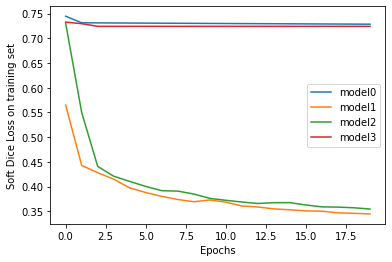

In [423]:
# Plot history of soft dice loss on training set (lower loss = better)
plotHistory("loss", "Soft Dice Loss on training set")

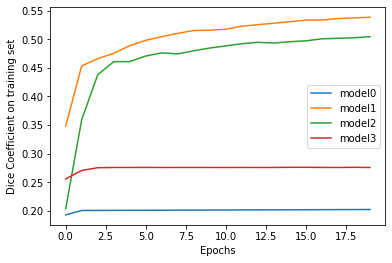

In [424]:
# Plot history of dice coefficient on training set (higher dice coefficient = better)
plotHistory("dice_coefficient", "Dice Coefficient on training set")

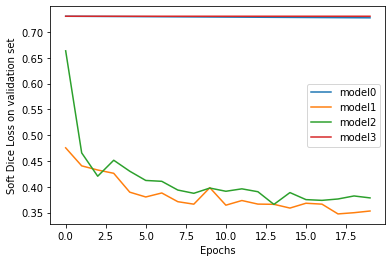

In [425]:
# Plot history of soft dice loss on validation set (lower loss = better)
plotHistory("val_loss", "Soft Dice Loss on validation set")

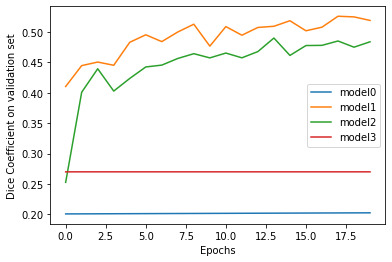

In [426]:
# Plot history of dice coefficient on training set (higher dice coefficient = better)
plotHistory("val_dice_coefficient", "Dice Coefficient on validation set")

In [427]:
evaluations = [{metric:{label:None for label in labels.values()} for metric in eval_metrics} for i in range(num_models)]

In [432]:
for i in range(num_models):
  pred = models[i].predict(val_images)
  for j in range(n_labels):
    TP = true_positives(val_labels[:, :, :, j], pred[:, :, :, j])
    TN = true_negatives(val_labels[:, :, :, j], pred[:, :, :, j])
    FP = false_positives(val_labels[:, :, :, j], pred[:, :, :, j])
    FN = false_negatives(val_labels[:, :, :, j], pred[:, :, :, j])
    accuracy = get_accuracy(val_labels[:, :, :, j], pred[:, :, :, j])
    prevalence = get_prevalence(val_labels[:, :, :, j])
    sensitivity = get_sensitivity(val_labels[:, :, :, j], pred[:, :, :, j])
    specificity = get_specificity(val_labels[:, :, :, j], pred[:, :, :, j])
    ppv = get_ppv(val_labels[:, :, :, j], pred[:, :, :, j])
    npv = get_npv(val_labels[:, :, :, j], pred[:, :, :, j])
    auc_value = roc_auc_score(val_labels[:, :, :, j].flatten(), pred[:, :, :, j].flatten())
    f1_score = get_f1_score(val_labels[:, :, :, j], pred[:, :, :, j])

    evaluations[i]["TP"][labels[j]] = TP
    evaluations[i]["TN"][labels[j]] = TN
    evaluations[i]["FP"][labels[j]] = FP
    evaluations[i]["FN"][labels[j]] = FN
    evaluations[i]["Accuracy"][labels[j]] = accuracy
    evaluations[i]["Prevalence"][labels[j]] = prevalence
    evaluations[i]["Sensitivity"][labels[j]] = sensitivity
    evaluations[i]["Specificity"][labels[j]] = specificity
    evaluations[i]["PPV"][labels[j]] = ppv
    evaluations[i]["NPV"][labels[j]] = npv
    evaluations[i]["AUC"][labels[j]] = auc_value
    evaluations[i]["F1"][labels[j]] = f1_score
    evaluations[i]["Threshold"][labels[j]] = 0.5

In [429]:
dfs = [pd.DataFrame(data=evaluations[i]) for i in range(num_models)]

In [430]:
for i in range(num_models):
  print(f"model{i}:")
  display(dfs[i])

model0:


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
background,6595520,0,604480,0,0.916044,0.916044,1.0,0.0,0.916044,0.000000,0.5,0.956183,0.5
edema,0,6872820,0,327180,0.954558,0.045442,0.0,1.0,0.000000,0.954558,0.5,0.000000,0.5
non-enhancing tumor,0,7068847,0,131153,0.981784,0.018216,0.0,1.0,0.000000,0.981784,0.5,0.000000,0.5
enhancing tumour,0,7053853,0,146147,0.979702,0.020298,0.0,1.0,0.000000,0.979702,0.5,0.000000,0.5


model1:


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
background,6567554,370077,234403,27966,0.963560,0.916044,0.995760,0.612224,0.965539,0.929741,0.986596,0.980417,0.5
edema,249228,6721143,151677,77952,0.968107,0.045442,0.761746,0.977931,0.621663,0.988535,0.982626,0.684612,0.5
non-enhancing tumor,102316,6758470,310377,28837,0.952887,0.018216,0.780127,0.956092,0.247923,0.995751,0.946678,0.376268,0.5
enhancing tumour,117812,6938531,115322,28335,0.980048,0.020298,0.806120,0.983651,0.505340,0.995933,0.990117,0.621239,0.5


model2:


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
background,6580565,350206,254274,14955,0.962607,0.916044,0.997733,0.579351,0.962797,0.959045,0.996482,0.979954,0.5
edema,116345,6601049,271771,210835,0.932971,0.045442,0.355599,0.960457,0.299769,0.969049,0.962360,0.325306,0.5
non-enhancing tumor,107025,6806256,262591,24128,0.960178,0.018216,0.816032,0.962852,0.289557,0.996468,0.975743,0.427443,0.5
enhancing tumour,144682,6827865,225988,1465,0.968409,0.020298,0.989976,0.967962,0.390326,0.999785,0.984083,0.559896,0.5


model3:


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
background,6595520,0,604480,0,0.916044,0.916044,1.0,0.0,0.916044,0.000000,0.499919,0.956183,0.5
edema,327180,0,6872820,0,0.045442,0.045442,1.0,0.0,0.045442,0.000000,0.500018,0.086933,0.5
non-enhancing tumor,131153,0,7068847,0,0.018216,0.018216,1.0,0.0,0.018216,0.000000,0.500000,0.035780,0.5
enhancing tumour,0,7053853,0,146147,0.979702,0.020298,0.0,1.0,0.000000,0.979702,0.499965,0.000000,0.5


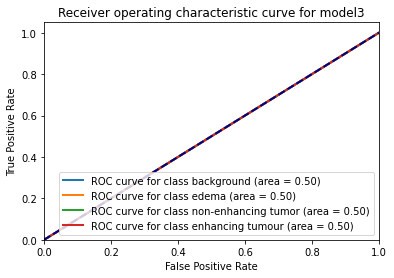

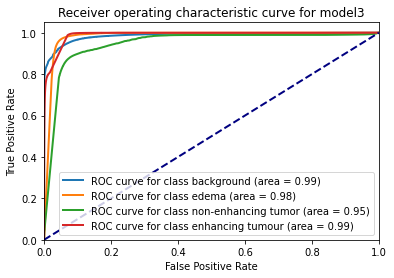

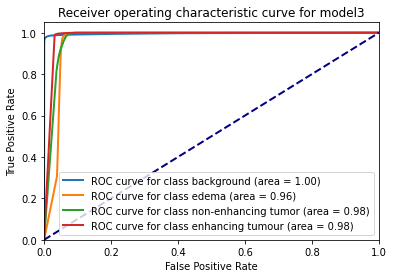

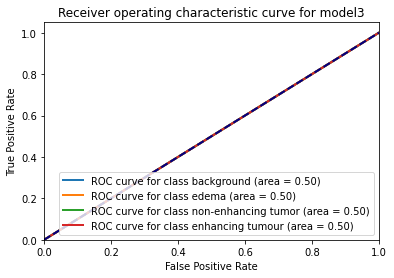

In [434]:
# Plot ROC curves for each model
for i in range(num_models):
  plotROCCurve(i, val_labels, val_images, n_labels=n_labels)

# Segment MRI Scan

In [442]:
def visualize(X, y):
    fig, ax = plt.subplots(1, 2, figsize=[10, 5], squeeze=False)

    ax[0][0].imshow(X[:, :, 0], cmap='Greys_r')
    ax[0][0].set_yticks([])
    ax[0][0].set_xticks([])
    ax[0][1].imshow(y[:, :, 1], cmap='Greys_r')
    ax[0][1].set_xticks([])
    ax[0][1].set_yticks([])

    fig.subplots_adjust(wspace=0, hspace=0)

In [436]:
def predict(model, x):
  if len(x.shape) > 3:
    return model.predict(x)
  else:
    return model.predict(np.array([x]))

In [437]:
def predict_and_visualize(model, X):
  visualize(X, predict(model, X)[0, :, :, :])

Randomly chosen image_idx: 45
Predicted segmentation:


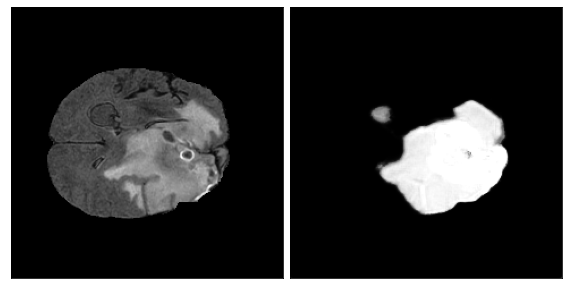

Actual segmentation:


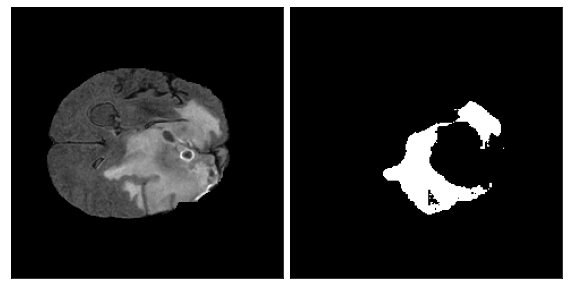

In [443]:
image_idx = np.random.randint(low=0, high=val_images.shape[0])
print(f"Randomly chosen image_idx: {image_idx}")
print("Predicted segmentation:")
predict_and_visualize(models[2], val_images[image_idx])
plt.show()
print("Actual segmentation:")
visualize(val_images[image_idx], val_labels[image_idx])